# Loading Libraries, Models, Datasets

In [ ]:
!pip install timm tensorboardX

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 2.6 MB/s eta 0:00:00


In [ ]:
import os
import sys
import pickle
import torch
import random
import shutil
import math
import zipfile
import numpy as np
from tqdm import tqdm
from copy import deepcopy
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from google.colab import drive,files


import torch.nn as nn
import torch.optim as optim
from timm import create_model
import torch.nn.functional as F
from torchvision.models import resnet50
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10, ImageFolder
from torch.utils.data import TensorDataset, DataLoader, Dataset

In [ ]:
drive.mount('/content/drive')

# Paths to the zip files in Google Drive
scrambled_zip_path = '/content/drive/My Drive/AdvML_custom_datasets/scrambled_images/images.zip'
noised_zip_path = '/content/drive/My Drive/AdvML_custom_datasets/noised_images/images.zip'
slic_zip_path =  '/content/drive/My Drive/AdvML_custom_datasets/slic.zip'
shapes_zip_path = '/content/drive/My Drive/AdvML_custom_datasets/shapes.zip'
texture_zip_path = '/content/drive/My Drive/AdvML_custom_datasets/Texture Bias Dataset.zip'


# Directories to extract the zip files
scrambled_extract_dir = '/content/scrambled_images'
noised_extract_dir = '/content/noised_images'
shapes_extract_dir = '/content/shapes'
slic_extract_dir = '/content/slic'
texture_extract_dir = '/content/texture'

# Function to unzip a file
def unzip_file(zip_path, extract_dir):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"Extracted '{zip_path}' to '{extract_dir}'")

# Unzip the files
unzip_file(scrambled_zip_path, scrambled_extract_dir)
unzip_file(noised_zip_path, noised_extract_dir)
unzip_file(shapes_zip_path, shapes_extract_dir)
unzip_file(slic_zip_path, slic_extract_dir)
unzip_file(texture_zip_path, texture_extract_dir)


# Count and print the number of files in each directory
def count_files(directory):
    file_count = sum([len(files) for _, _, files in os.walk(directory)])
    print(f"Number of files in '{directory}': {file_count}")

count_files(scrambled_extract_dir)
count_files(noised_extract_dir)
count_files(shapes_extract_dir)
count_files(slic_extract_dir)
count_files(texture_extract_dir)

Mounted at /content/drive
Extracted '/content/drive/My Drive/AdvML_custom_datasets/scrambled_images/images.zip' to '/content/scrambled_images'
Extracted '/content/drive/My Drive/AdvML_custom_datasets/noised_images/images.zip' to '/content/noised_images'
Extracted '/content/drive/My Drive/AdvML_custom_datasets/shapes.zip' to '/content/shapes'
Extracted '/content/drive/My Drive/AdvML_custom_datasets/slic.zip' to '/content/slic'
Extracted '/content/drive/My Drive/AdvML_custom_datasets/Texture Bias Dataset.zip' to '/content/texture'
Number of files in '/content/scrambled_images': 10001
Number of files in '/content/noised_images': 10001
Number of files in '/content/shapes': 10000
Number of files in '/content/slic': 10000
Number of files in '/content/texture': 10010


In [ ]:
tensor_path = '/content/scrambled_images/content/generated_dataset/images/img_0000.pt'
tensor = torch.load(tensor_path)
print(f"Size of the loaded tensor in Scrambled Dataset: {tensor.size()}")

tensor_path = '/content/noised_images/content/generated_dataset/images/img_0000.pt'
tensor = torch.load(tensor_path)
print(f"Size of the loaded tensor in Noisy dataset: {tensor.size()}")

image_path = f"{shapes_extract_dir}/img_1.png"
image = Image.open(image_path)
transform = transforms.ToTensor()
image_tensor = transform(image)
print(f"Size of the loaded tensor in Shape dataset: {image_tensor.size()}")


image_path = f"{slic_extract_dir}/img_1.png"
image = Image.open(image_path)
transform = transforms.ToTensor()
image_tensor = transform(image)
print(f"Size of the loaded tensor in Slic dataset: {image_tensor.size()}")

Size of the loaded tensor in Scrambled Dataset: torch.Size([3, 32, 32])
Size of the loaded tensor in Noisy dataset: torch.Size([3, 80, 80])
Size of the loaded tensor in Shape dataset: torch.Size([1, 224, 224])
Size of the loaded tensor in Slic dataset: torch.Size([3, 330, 330])


<ipython-input-7-b41caca01dba>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load(tensor_path)
<ipython-input-7-b41caca01dba>:6: FutureWarning: You are usi

In [ ]:
base_dir = '/content/texture'

# Function to get all partition paths
def get_partition_paths(base_dir):
    # Navigate to the deeper subdirectory containing images and labels.txt
    return [os.path.join(base_dir, f"partition{i}", f"partition{i}") for i in range(1, 11)]

# Function to load images and labels from a single partition
def load_partition_data(partition_path):
    images = []
    labels = []

    # Path to the labels.txt file
    label_file = os.path.join(partition_path, 'labels.txt')

    # Read the labels.txt file
    with open(label_file, 'r') as f:
        for line in f:
            img_name, label = line.strip().split()  # Split filename and label
            img_path = os.path.join(partition_path, img_name)  # Full path to image
            label = int(label)  # Convert label to integer

            # Load the image
            img = Image.open(img_path).convert('RGB')  # Ensure RGB format

            images.append((img_path, img))  # Store tuple of (image path, image object)
            labels.append(label)

    return images, labels

# Load data from all partitions
all_images = []  # To store tuples of (image path, image data)
all_labels = []  # To store corresponding labels

for partition_path in get_partition_paths(base_dir):
    images, labels = load_partition_data(partition_path)
    all_images.extend(images)
    all_labels.extend(labels)

# Print some debug info
print(f"Loaded {len(all_images)} images and {len(all_labels)} labels.")
print(f"Example Image Path: {all_images[0][0]}, Label: {all_labels[0]}")

# # Preprocessing for PyTorch
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # CIFAR-10 images are 32x32
    transforms.ToTensor(),       # Convert image to tensor
])

# Apply transformations to images
processed_images = [transform(img[1]) for img in all_images]  # img[1] contains the actual image data
all_labels = torch.tensor(all_labels)  # Convert labels to tensor

# Create a PyTorch DataLoader
texture_bias_dataset = TensorDataset(torch.stack(processed_images), all_labels)
texture_bias_loader = DataLoader(texture_bias_dataset, batch_size=64, shuffle=False)

print(texture_bias_dataset[0][0].shape, texture_bias_dataset[0][1])

Loaded 10000 images and 10000 labels.
Example Image Path: /content/texture/partition1/partition1/img_0000.png, Label: 3
torch.Size([3, 224, 224]) tensor(3)


In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, image_dir, labels_file, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        # Load image paths
        self.image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('.pt')])
        # Parse labels.txt file
        self.labels = []
        with open(labels_file, 'r') as f:
            for line in f:
                parts = line.strip().split()  # Split by whitespace
                img_name, label = parts[0], int(parts[1])  # Extract filename and label
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load tensor image
        image = torch.load(self.image_paths[idx])  # Assuming saved as .pt tensor files
        label = self.labels[idx]

        # Convert tensor to PIL Image for transforms
        image = transforms.ToPILImage()(image)

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, label

# Paths
scrambled_dir = '/content/scrambled_images/content/generated_dataset/images'
scrambled_labels = '/content/scrambled_images/content/generated_dataset/labels.txt'

noised_dir = '/content/noised_images/content/generated_dataset/images'
noised_labels = '/content/noised_images/content/generated_dataset/labels.txt'

# Transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor()          # Convert to tensor
])

# Datasets
scrambled_dataset = CustomImageDataset(scrambled_dir, scrambled_labels, transform=transform)
noised_dataset = CustomImageDataset(noised_dir, noised_labels, transform=transform)

# DataLoaders
scrambled_loader = DataLoader(scrambled_dataset, batch_size=64, shuffle=True)
noised_loader = DataLoader(noised_dataset, batch_size=64, shuffle=True)

# Verify dataset
for images, labels in scrambled_loader:
    print('scrambled loader',images.shape)  # Should print torch.Size([32, 3, 224, 224]) for RGB images
    # print(labels)
    break

# Verify dataset
for images, labels in noised_loader:
    print('noised loader',images.shape)  # Should print torch.Size([32, 3, 224, 224]) for RGB images
    # print(labels)
    break

scrambled loader torch.Size([64, 3, 224, 224])
noised loader torch.Size([64, 3, 224, 224])


<ipython-input-5-e7135c4edcdc>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image = torch.load(self.image_paths[idx])  # Assuming saved as .pt tensor files


In [ ]:
class ImageLabelDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        """
        Args:
            image_dir (str): Directory with all the images (.png files).
            label_dir (str): Directory with corresponding labels (.pt files).
            transform (callable, optional): Optional transform to apply to images.
        """
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform

        # Get sorted list of images and labels
        self.image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('.png')])
        # Parse labels.txt file
        self.labels = []
        with open(label_dir, 'r') as f:
            for line in f:
                parts = line.strip().split()  # Split by whitespace
                img_name, label = parts[0], int(parts[1])  # Extract filename and label
                self.labels.append(label)


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')  # Ensure image is RGB

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        # Load label tensor
        label = self.labels[idx]

        return image, label

# Paths
shapes_image_dir = '/content/shapes'
shapes_label_dir ='/content/scrambled_images/content/generated_dataset/labels.txt'

slic_image_dir = '/content/slic'
slic_label_dir = '/content/scrambled_images/content/generated_dataset/labels.txt'

# Transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Datasets
shapes_dataset = ImageLabelDataset(shapes_image_dir, shapes_label_dir, transform=transform)
slic_dataset = ImageLabelDataset(slic_image_dir, slic_label_dir, transform=transform)

# Dataloaders
shapes_loader = DataLoader(shapes_dataset, batch_size=64, shuffle=True)
slic_loader = DataLoader(slic_dataset, batch_size=64, shuffle=True)

# Verify dataset
for images, labels in shapes_loader:
    print(f"Shapes dataset - images: {images.shape}, labels: {labels.shape}")
    break

for images, labels in slic_loader:
    print(f"SLIC dataset - images: {images.shape}, labels: {labels.shape}")
    break


Shapes dataset - images: torch.Size([64, 3, 224, 224]), labels: torch.Size([64])
SLIC dataset - images: torch.Size([64, 3, 224, 224]), labels: torch.Size([64])


<ipython-input-20-afd0b41b0da7>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image = torch.load(self.image_paths[idx])  # Assuming saved as .pt tensor files


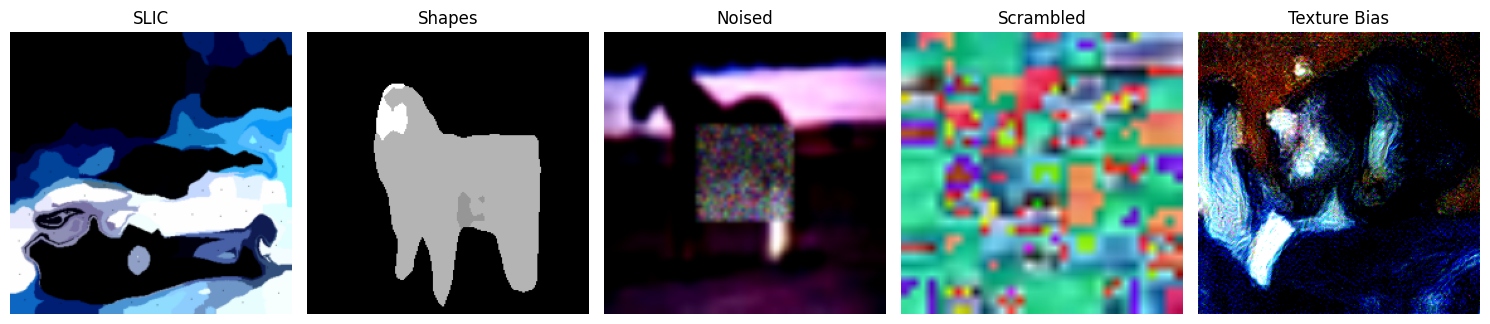

In [ ]:
# Function to get the first image and label from a DataLoader
def get_first_image(loader):
    for images, _ in loader:  # Only interested in images
        first_image = images[0]  # First image in the batch
        return first_image
    return None

# Load the first image from each loader
slic_image = get_first_image(slic_loader)
shapes_image = get_first_image(shapes_loader)
noised_image = get_first_image(noised_loader)
scrambled_image = get_first_image(scrambled_loader)
texture_bias_image = get_first_image(texture_bias_loader)

# List of images and titles
images = [slic_image, shapes_image, noised_image, scrambled_image, texture_bias_image]
titles = ['SLIC', 'Shapes', 'Noised', 'Scrambled', 'Texture Bias']

# Plot the images
plt.figure(figsize=(15, 5))
for i, (img, title) in enumerate(zip(images, titles)):
    # Convert tensor to a PIL image for plotting
    if i==3:
      img_pil = img.permute(1, 2, 0)
    else:
      img_pil = F.to_pil_image(img)
    plt.subplot(1, 5, i + 1)
    plt.imshow(img_pil)
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def create_vit_model(num_classes=10):
    """Create a ViT model with a dynamic number of output classes."""
    model = create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes)

    #Freeze all layers in the VIT model
    for param in model.parameters():
        param.requires_grad = False

    model.head = torch.nn.Linear(model.head.in_features, num_classes)  # Replace the classifier head

    # Get features model (backbone)
    # print(nn.Sequential(*list(model.children())))
    # print("--------------------------------(--------------------------------------)------------")
    vit_features_model = nn.Sequential(*list(model.children())[:-1])  # Exclude the classifier head
    # print(vit_features_model)
    # print("-----------------------------------(--------------------------------------)---------")

    return model, vit_features_model

def create_resnet_model(num_classes=10):
    """Create a RESNET model with a dynamic number of output classes."""
    model = resnet50(pretrained=True)

    # Freeze all layers in the RESNET model
    # for param in model.parameters():
    #     param.requires_grad = False

    num_features = model.fc.in_features       # Get the number of input features of the last layer
    model.fc = nn.Linear(num_features, num_classes)      # Replace the last fully connected layer with a new one with `num_classes` outputs

    # Get features model (backbone)
    # print(nn.Sequential(*list(model.children())))
    # print("-----------------------(--------------------------------------)---------------")

    features_model = nn.Sequential(*list(model.children())[:-2])  # Extract all layers except the last fully connected layer and the global adaptive average pool 2d layer
    # print(features_model)
    # print("----------------------------(--------------------------------------)----------")
    return model, features_model


def get_model(name):
  if name == 'student':
    resnet_model, resnet_features_model = create_resnet_model()
    return resnet_model, resnet_features_model
  elif name == 'teacher':
    vit_model, vit_features_model = create_vit_model()
    return vit_model, vit_features_model
  else:
    raise ValueError(f"Unsupported model name: {name}")


def finetune_model(model, train_loader, num_epochs=3, alpha=1e-3):
    """Fine-tune the model on the training data."""
    print("Finetuning the model on this data")
    model.train()
    model = model.to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=alpha)
    num_batches = len(train_loader)

    for epoch in range(num_epochs):
        running_loss = 0.0
        # running_accuracy = 0.0
        correct = 0
        total = 0
        for batch_index, (inputs, labels) in enumerate(train_loader):

            batch_size = inputs.size(0)
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            if batch_index % 300 == 0 or batch_index == 750:
                print(f'Batch {batch_index + 1}/{num_batches} - Loss: {loss.item():.4f} Accuracy: {(correct/total) * 100:.2f}%')

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy =  correct / total
        print(f'------------------------->Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f} Accuracy : {epoch_accuracy * 100:.2f}%')


    return epoch_loss, epoch_accuracy

def evaluate_model(model, data_loader,device):
    """Evaluate the models using a basic testing loop"""
    print("Evaluating the model")
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    num_batches = len(data_loader)  # Get total number of batches

    with torch.no_grad():
        for batch_index, (images, labels) in enumerate(data_loader):

            batch_size = images.size(0)
            if batch_size < 32:
              print(f"skipping last batch of size {batch_size} --- gives shape error")
              break

            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Print progress every 10 batches (you can adjust this as needed)
            if batch_index % 10 == 0:
                print(f'Batch {batch_index + 1}/{num_batches} - Accuracy: { (correct/total) * 100:.2f}%')

    accuracy = correct / total
    print(f'Final Accuracy: {accuracy * 100:.2f}%')
    return accuracy

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # works for all models
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.2435, 0.2616))  # CIFAR-10 mean and std
])

mean, std = (0.4914, 0.4822, 0.4465), (0.247, 0.2435, 0.2616)

train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# print(f'Total number of images in CIFAR 10 test_loader: {len(test_dataset)}')

cifar10_classes = [ 'airplane', 'automobile',  'ship', 'truck' ,'bird', 'cat', 'deer', 'dog', 'frog', 'horse']
num_classes = len(cifar10_classes)

100%|██████████| 170M/170M [00:02<00:00, 78.5MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Saving, Restoring **Model** Utils

**Saving model weights**

In [ ]:
# Define file paths for each model
model_paths = {
    'teacher_model': '/content/teacher_model.pth',
    'student_indep': '/content/student_indep.pth',
    'student_lm': '/content/student_lm.pth',
    'student_crd': '/content/student_crd.pth',
    'student_capd': '/content/student_capd.pth',
    'student_sskd': '/content/student_sskd.pth'
}

# Save each model's state dictionary
torch.save(teacher_model.state_dict(), model_paths['teacher_model'])
torch.save(student_indep.state_dict(), model_paths['student_indep'])
torch.save(student_crd.state_dict(), model_paths['student_crd'])
torch.save(student_lm.state_dict(), model_paths['student_lm'])
# torch.save(student_capd.state_dict(), model_paths['student_capd'])
# torch.save(student_sskd.state_dict(), model_paths['student_sskd'])

paths = [
    '/content/teacher_model.pth',
    '/content/student_sskd.pth',
    '/content/student_capd.pth',
    '/content/student_crd.pth',
    '/content/student_lm.pth',
    '/content/student_indep.pth'
]

# # Zip file path
zip_path = '/content/models.zip'

# Create a zip file containing all model files
with zipfile.ZipFile(zip_path, 'w') as zipf:
    for model_path in paths:
        if os.path.exists(model_path):
            zipf.write(model_path, os.path.basename(model_path))
        else:
            print(f"File not found: {model_path}")

# Check and print the size of the zip file
zip_size = os.path.getsize(zip_path) / (1024 * 1024)  # Convert to MB
print(f"Zip file size: {zip_size:.2f} MB")


# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Define the path in Google Drive where you want to save the zip file
drive_path = '/content/drive/MyDrive/atml_proj_models.zip'

# Step 3: Move the zip file to Google Drive
shutil.move('/content/models.zip', drive_path)

print(f"Zip file moved to Google Drive at: {drive_path}")

File not found: /content/student_sskd.pth
File not found: /content/student_capd.pth
Zip file size: 597.56 MB
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Zip file moved to Google Drive at: /content/drive/MyDrive/atml_proj_models.zip


**Getting model weights**

In [ ]:
# Define file paths for each model
model_paths = {
    'teacher_model': '/content/teacher_model.pth',
    'student_capd': '/content/student_capd.pth',
    'student_crd': '/content/student_crd.pth',
    'student_lm': '/content/student_lm.pth',
    'student_sskd': '/content/student_sskd.pth',
    'student_indep': '/content/student_indep.pth'
}

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Define paths
drive_path = '/content/drive/MyDrive/atml_proj_models.zip'  # Path to the zip file in Google Drive
destination_path = '/content/models.zip'  # Destination in Colab's content directory

# Step 3: Copy the zip file from Google Drive to /content
shutil.copy(drive_path, destination_path)

# Step 4: Unzip the file in /content
with zipfile.ZipFile(destination_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

print("Files extracted to /content/")


#Init the models
teacher_model, _ = create_vit_model()
student_crd, _ = create_resnet_model()
student_lm, _ = create_resnet_model()
student_indep, _ = create_resnet_model()

# student_sskd, _ = create_resnet_model()
# student_capd, _ = create_resnet_model()

# Load each model's state dictionary
teacher_model.load_state_dict(torch.load(model_paths['teacher_model']))
student_crd.load_state_dict(torch.load(model_paths['student_crd']))
student_lm.load_state_dict(torch.load(model_paths['student_lm']))
student_indep.load_state_dict(torch.load(model_paths['student_indep']))
# teacher_model.load_state_dict(torch.load(model_paths['teacher_model'], map_location=torch.device('cpu')))
# student_crd.load_state_dict(torch.load(model_paths['student_crd'], map_location=torch.device('cpu')))
# student_lm.load_state_dict(torch.load(model_paths['student_lm'], map_location=torch.device('cpu')))
# student_indep.load_state_dict(torch.load(model_paths['student_indep'], map_location=torch.device('cpu')))
# student_sskd.load_state_dict(torch.load(model_paths['student_sskd']))
# student_capd.load_state_dict(torch.load(model_paths['student_capd']))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files extracted to /content/


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 212MB/s]
<ipython-input-9-01cfb9c64166>:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possi

<All keys matched successfully>

# Knowledge Distillation Utils

In [ ]:
def get_features_and_logits(model,feature_model,inputs,student=True, crd=False):
    #will return the same logits as long as model.eval()  is set (i.e. no learning is happening hence same LOGITs)
    if not student:
      model.eval()
      feature_model.eval()
      vit_transform = transforms.Compose([
          transforms.Resize((224, 224)),
          # transforms.ToTensor()
      ])
      inputs = vit_transform(inputs)
      features = feature_model(inputs)
      # if crd:
      return features,None    #teacher logits NOT required in CRD / Hint
      # logits = model.classifier(features.view(features.size(0), -1))  #to save on time (as teacher doesnt need to LEARN)
    else:
      model.train()
      features = feature_model(inputs)
      logits = model(inputs) #actual student model does need to LEARN hence repeating it twice

    # print("feature shape",features.shape,"logits shape",logits.shape)
    return features, logits

def get_channel_num(model,name):


    if name == 'resnet':
      return 2048
      channel_nums = []
      for layer in model.modules():        # find all Conv2d layers in the model
          if isinstance(layer, nn.Conv2d):
              channel_nums.append(layer.out_channels)

      # Check if there are enough Conv2d layers
      if len(channel_nums) < 2:
          raise ValueError("Model has fewer than two Conv2d layers.")

      # print(channel_nums,name)
      return channel_nums[-2]      # Return the output channels of the second-to-last Conv2d layer

    elif name == 'vit':
        return 150528
        # For ViT, return the embedding dimension (projection size)
        for layer in model.modules():
            # print(layer)
            if isinstance(layer, nn.Linear):
                # Typically, the first Linear layer defines the embedding size
                return layer.out_features

        raise ValueError("No Linear layers found in the ViT model.")

    else:
        raise ValueError(f"Unsupported model type: {name}")

print((2048, 'resnet', 150528, 'vit'))

(2048, 'resnet', 150528, 'vit')


In [ ]:
def train_student(student, teacher, train_loader, kd, num_epochs=10, alpha=1e-3,  features_student=None, features_teacher=None):
    """Train the model on the training data."""
    student.train()
    teacher.eval()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(student.parameters(), lr=alpha)
    num_batches = len(train_loader)

    if kd is None:
      print("Training the student on this data independently")
    else:
      print("Distilling the knowledge and training the student on this data",kd.__class__.__name__)

    for epoch in range(num_epochs):
        running_loss = 0.0
        running_accuracy = 0.0
        correct = 0
        total = 0
        for batch_index, (inputs, labels) in enumerate(train_loader):

            batch_size = inputs.size(0)
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            if kd is None:      #independent student
              outputs = student(inputs)
              distillation_loss = 0.0
            else:
              if kd.__class__.__name__ in [ 'LogitMatching' , 'LabelSmoothingRegularization', 'DecoupledLogitMatching'] :

                  #get teacher's logits and student's logits
                  with torch.no_grad():
                    teacher_outputs = teacher(inputs)
                  outputs = student(inputs)

                  if kd.__class__.__name__ == 'LogitMatching':
                    distillation_loss = kd(outputs, teacher_outputs)
                  elif kd.__class__.__name__ == 'LabelSmoothingRegularization':
                   distillation_loss = kd(outputs,labels)
                  else:     #DecoupledLogitMatching
                    distillation_loss = kd(outputs, teacher_outputs, labels)

              elif kd.__class__.__name__ == 'FeatureMatching':
                  #get features of student , teacher and logits of student
                  feat_s, outputs = get_features_and_logits(student,features_student,inputs)
                  feat_t, _ = get_features_and_logits(teacher,features_teacher,inputs,student=False)
                  distillation_loss = kd(feat_s, feat_t)

            classification_loss = criterion(outputs, labels)
            total_loss = classification_loss + distillation_loss
            total_loss.backward()
            optimizer.step()

            running_loss += total_loss.item()
            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            if batch_index % 200 == 0 or batch_index == 750:
                print(f'Batch {batch_index + 1}/{num_batches} - Loss: {total_loss.item():.4f} Accuracy: {(correct/total) * 100:.2f}%')

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct/total
        print(f'------------------------->Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f} Accuracy : {epoch_accuracy * 100:.2f}%')

    return epoch_loss, epoch_accuracy

In [ ]:
def plot_accuracies(accuracies, model_labels, title='Model Accuracies'):
    """
    Plots the accuracies of different models.

    Parameters:
    accuracies (list of float): A list of accuracy values for each model.
    model_labels (list of str): A list of labels corresponding to each model.

    """
    # Ensure the inputs are valid
    if len(accuracies) != len(model_labels):
        raise ValueError("The number of accuracies must match the number of model labels.")

    # Create the plot
    plt.figure(figsize=(8, 6))
    plt.bar(model_labels, accuracies)

    # Adding title and labels
    plt.title(title)
    plt.xlabel('Models')
    plt.ylabel('Accuracy')

    # Optionally, add accuracy values on top of the bars
    for i, acc in enumerate(accuracies):
        plt.text(i, acc, f'{acc:.2f}', ha='center', va='bottom')

    # Show the plot
    plt.xticks(rotation=45)  # Rotate x labels for better visibility
    plt.tight_layout()
    plt.show()


In [ ]:
class CIFAR10IdxSample(CIFAR10):          #loaded for Knowledge Distillation with CRD
	def __init__(self, root, train=True, transform=None, target_transform=None, download=False, n=4096, mode='exact', percent=1.0):
		super().__init__(root=root, train=train, download=download,transform=transform, target_transform=target_transform)
		self.n = n
		self.mode = mode

		num_classes = 10
		num_samples = len(self.data)
		labels = self.targets

		self.cls_positive = [[] for _ in range(num_classes)]
		for i in range(num_samples):
			self.cls_positive[labels[i]].append(i)

		self.cls_negative = [[] for _ in range(num_classes)]
		for i in range(num_classes):
			for j in range(num_classes):
				if j == i:
					continue
				self.cls_negative[i].extend(self.cls_positive[j])

		self.cls_positive = [np.asarray(self.cls_positive[i]) for i in range(num_classes)]
		self.cls_negative = [np.asarray(self.cls_negative[i]) for i in range(num_classes)]

		if 0 < percent < 1:
			num = int(len(self.cls_negative[0]) * percent)
			self.cls_negative = [np.random.permutation(self.cls_negative[i])[0:num]
								 for i in range(num_classes)]

		self.cls_positive = np.asarray(self.cls_positive)
		self.cls_negative = np.asarray(self.cls_negative)

	def __getitem__(self, index):
		img, target = self.data[index], self.targets[index]

		img = Image.fromarray(img)
		if self.transform is not None:
			img = self.transform(img)

		if self.target_transform is not None:
			target = self.target_transform(target)

		if self.mode == 'exact':
			pos_idx = index
		elif self.mode == 'relax':
			pos_idx = np.random.choice(self.cls_positive[target], 1)[0]
		else:
			raise NotImplementedError(self.mode)
		replace = True if self.n > len(self.cls_negative[target]) else False
		neg_idx = np.random.choice(self.cls_negative[target], self.n, replace=replace)
		sample_idx = np.hstack((np.asarray([pos_idx]), neg_idx))

		return img, target, index, sample_idx

# Logit Matching and Contrastive

In [ ]:
class LogitMatching(nn.Module):  #smoothes teacher logits as well (going from Peaky dist to Uniform dist by increasing Temperature T)
	def __init__(self, T=3.0):
		super(LogitMatching, self).__init__()
		self.T = T      #Temperature for Soft Targets ... lower the T, less the smoothing, less the error

	def forward(self, out_s, out_t):
    # loss = F.mse_loss(out_s, out_t)
		loss = self.T * self.T * F.kl_div(
                                        F.log_softmax(out_s/self.T, dim=1),
                                        F.softmax(out_t/self.T, dim=1),
                                        reduction='batchmean'
          )  #cross entropy loss of softened probabilities

		return loss

class CRD(nn.Module):
	'''
	Contrastive Representation Distillation
	https://openreview.net/pdf?id=SkgpBJrtvS

	includes two symmetric parts:
	(a) using teacher as anchor, choose positive and negatives over the student side
	(b) using student as anchor, choose positive and negatives over the teacher side

	Args:
		s_dim: the dimension of student's feature
		t_dim: the dimension of teacher's feature
		feat_dim: the dimension of the projection space
		nce_n: number of negatives paired with each positive
		nce_t: the temperature
		nce_mom: the momentum for updating the memory buffer
		n_data: the number of samples in the training set, which is the M in Eq.(19)
	'''
	def __init__(self, s_dim, t_dim, n_data, feat_dim=128, nce_n=4096, nce_t=0.1, nce_mom=0.5):
		super(CRD, self).__init__()
		self.embed_s = Embed(s_dim, feat_dim)
		self.embed_t = Embed(t_dim, feat_dim)
		self.contrast = ContrastMemory(feat_dim, n_data, nce_n, nce_t, nce_mom)
		self.criterion_s = ContrastLoss(n_data)
		self.criterion_t = ContrastLoss(n_data)

	def forward(self, feat_s, feat_t, idx, sample_idx):
		feat_s = self.embed_s(feat_s)
		feat_t = self.embed_t(feat_t)
		out_s, out_t = self.contrast(feat_s, feat_t, idx, sample_idx)
		loss_s = self.criterion_s(out_s)
		loss_t = self.criterion_t(out_t)
		loss = loss_s + loss_t

		return loss


class Embed(nn.Module):
	def __init__(self, in_dim, out_dim):
		super(Embed, self).__init__()
		self.linear = nn.Linear(in_dim, out_dim)

	def forward(self, x):
		x = x.view(x.size(0), -1).to(self.linear.weight.device)
	 	# x = x.view(x.size(0), -1).to(self.linear.weight.device)
		x = self.linear(x)
		x = F.normalize(x, p=2, dim=1)

		return x


class ContrastLoss(nn.Module):
	'''
	contrastive loss, corresponding to Eq.(18)
	'''
	def __init__(self, n_data, eps=1e-7):
		super(ContrastLoss, self).__init__()
		self.n_data = n_data
		self.eps = eps

	def forward(self, x):
		bs = x.size(0)
		N  = x.size(1) - 1
		M  = float(self.n_data)

		# loss for positive pair
		pos_pair = x.select(1, 0)
		log_pos  = torch.div(pos_pair, pos_pair.add(N / M + self.eps)).log_()

		# loss for negative pair
		neg_pair = x.narrow(1, 1, N)
		log_neg  = torch.div(neg_pair.clone().fill_(N / M), neg_pair.add(N / M + self.eps)).log_()

		loss = -(log_pos.sum() + log_neg.sum()) / bs

		return loss


class ContrastMemory(nn.Module):
    def __init__(self, feat_dim, n_data, nce_n, nce_t, nce_mom):
        super(ContrastMemory, self).__init__()
        self.N = nce_n
        self.T = nce_t
        self.momentum = nce_mom
        self.Z_t = None
        self.Z_s = None

        stdv = 1. / math.sqrt(feat_dim / 3.)
        self.register_buffer('memory_t', torch.rand(n_data, feat_dim).mul_(2 * stdv).add_(-stdv))
        self.register_buffer('memory_s', torch.rand(n_data, feat_dim).mul_(2 * stdv).add_(-stdv))

    def forward(self, feat_s, feat_t, idx, sample_idx):
        bs = feat_s.size(0)
        feat_dim = self.memory_s.size(1)
        n_data = self.memory_s.size(0)
        sample_idx = sample_idx.to(self.memory_s.device)

        # using teacher as anchor
        weight_s = torch.index_select(self.memory_s, 0, sample_idx.view(-1)).detach()
        weight_s = weight_s.view(bs, self.N + 1, feat_dim)
        out_t = torch.bmm(weight_s, feat_t.view(bs, feat_dim, 1)).squeeze().contiguous()
        out_t = torch.exp(out_t / self.T)

        # using student as anchor
        weight_t = torch.index_select(self.memory_t, 0, sample_idx.view(-1)).detach()
        weight_t = weight_t.view(bs, self.N + 1, feat_dim)
        out_s = torch.bmm(weight_t, feat_s.view(bs, feat_dim, 1)).squeeze().contiguous()
        out_s = torch.exp(out_s / self.T)

        # set Z if haven't been set yet
        if self.Z_t is None:
            self.Z_t = (out_t.mean() * n_data).detach().item()
        if self.Z_s is None:
            self.Z_s = (out_s.mean() * n_data).detach().item()

        out_t = torch.div(out_t, self.Z_t)
        out_s = torch.div(out_s, self.Z_s)

        # update memory
        with torch.no_grad():
            idx = idx.to(self.memory_t.device)
            pos_mem_t = torch.index_select(self.memory_t, 0, idx.view(-1))
            pos_mem_t.mul_(self.momentum)
            pos_mem_t.add_(torch.mul(feat_t, 1 - self.momentum))
            pos_mem_t = F.normalize(pos_mem_t, p=2, dim=1)
            self.memory_t.index_copy_(0, idx, pos_mem_t)

            pos_mem_s = torch.index_select(self.memory_s, 0, idx.view(-1))
            pos_mem_s.mul_(self.momentum)
            pos_mem_s.add_(torch.mul(feat_s, 1 - self.momentum))
            pos_mem_s = F.normalize(pos_mem_s, p=2, dim=1)
            self.memory_s.index_copy_(0, idx, pos_mem_s)

        return out_s, out_t


In [ ]:
train_crd_transform = transforms.Compose([
    # transforms.Pad(4, padding_mode='reflect'),
    # transforms.RandomCrop(32),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
		transforms.Normalize(mean=mean,std=std)
])

train_crd_dataset = CIFAR10IdxSample

train_crd_loader = torch.utils.data.DataLoader(
			train_crd_dataset(
              root  = './datasets',
						  transform = train_crd_transform,
						  train     = True,
						  download  = True,
						  n         = 4096,
						  mode      = 'exact'
      ),
			batch_size=32, shuffle=True, num_workers=4, pin_memory=True)

100%|██████████| 170M/170M [00:12<00:00, 13.3MB/s]


Extracting ./datasets/cifar-10-python.tar.gz to ./datasets


In [ ]:
def train_student_crd(student, features_student, teacher, features_teacher, train_loader, kd, num_epochs=10, alpha=1e-4):
    """Train the model on the training data for CRD """
    print("Distilling the knowledge and training the student on this data for CRD")
    student.train()
    teacher.eval()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(student.parameters(), lr=alpha)
    num_batches = len(train_loader)

    for epoch in range(num_epochs):
      running_loss = 0.0
      correct = 0
      total = 0
      for batch_index, (img, target, idx, sample_idx ) in enumerate(train_loader, start=1):
        # print(img.shape, target.shape, idx.shape, sample_idx.shape)
        img = img.to(device)
        target = target.to(device)
        idx = idx.to(device)
        sample_idx = sample_idx.to(device)

        #get features and logits
        # print(img.shape)
        feat_s, logit_s = get_features_and_logits(student,features_student,img)
        feat_t, _ = get_features_and_logits(teacher,features_teacher,img,student=False, crd=True)


        feat_s = feat_s.to(device)
        feat_t = feat_t.to(device)
        logit_s = logit_s.to(device)


        #get total loss
        kd_lambda = 1   # 0.2   #for CRD
        # print(feat_t.shape, feat_s.shape)
        kd_loss  = kd(feat_s, feat_t, idx, sample_idx) * kd_lambda
        cls_loss = criterion(logit_s, target)
        total_loss = cls_loss + kd_loss
        # print("total loss",total_loss, "crd + cls", kd_loss , cls_loss)


        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        running_loss += total_loss.item()

        # # Calculate accuracy
        _, predicted = torch.max(logit_s, 1)
        predicted= predicted.to(device)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        if batch_index % 200 == 0 or batch_index in [1,750]:
            print(f'Batch {batch_index }/{num_batches} - Loss: {total_loss.item():.4f} Accuracy: {(correct/total) * 100:.2f}%')

      epoch_loss = running_loss / len(train_loader)
      epoch_accuracy = correct / total
      print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')
    return epoch_loss, epoch_accuracy
    # return epoch_loss


# Teacher, Indep Stu, LM , CRD

In [ ]:
# 10 minutes runtime
teacher_model, features_teacher = get_model('teacher')
epoch_loss, epoch_accuracy = finetune_model(teacher_model, train_loader, num_epochs=1) #else it overfits (goes to 100% byend of 2 epochs)
teacher_model.eval()
print(f'Teacher Accuracy: {epoch_accuracy * 100:.2f}%')

Finetuning the model on this data
Batch 1/1563 - Loss: 2.2382 Accuracy: 12.50%
Batch 301/1563 - Loss: 0.2941 Accuracy: 91.57%
Batch 601/1563 - Loss: 0.2696 Accuracy: 93.02%
Batch 751/1563 - Loss: 0.0880 Accuracy: 93.36%
Batch 901/1563 - Loss: 0.2150 Accuracy: 93.59%
Batch 1201/1563 - Loss: 0.2377 Accuracy: 93.95%
Batch 1501/1563 - Loss: 0.0502 Accuracy: 94.20%
------------------------->Epoch [1/1], Loss: 0.1811 Accuracy : 94.24%


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [ ]:
student_indep, features_student = get_model('student')
epoch_loss, epoch_accuracy = finetune_model(student_indep, train_loader, num_epochs=2)

Finetuning the model on this data
Batch 1/1563 - Loss: 2.2973 Accuracy: 12.50%
Batch 301/1563 - Loss: 1.1932 Accuracy: 47.83%
Batch 601/1563 - Loss: 0.8998 Accuracy: 54.68%
Batch 751/1563 - Loss: 1.1079 Accuracy: 56.80%
Batch 901/1563 - Loss: 0.6592 Accuracy: 59.16%
Batch 1201/1563 - Loss: 0.9783 Accuracy: 62.20%
Batch 1501/1563 - Loss: 0.5642 Accuracy: 64.79%
------------------------->Epoch [1/2], Loss: 0.9784 Accuracy : 65.31%
Batch 1/1563 - Loss: 0.3574 Accuracy: 87.50%
Batch 301/1563 - Loss: 0.8816 Accuracy: 78.82%
Batch 601/1563 - Loss: 0.2806 Accuracy: 78.96%
Batch 751/1563 - Loss: 0.5497 Accuracy: 79.27%
Batch 901/1563 - Loss: 0.4788 Accuracy: 79.47%
Batch 1201/1563 - Loss: 0.4934 Accuracy: 79.77%
Batch 1501/1563 - Loss: 0.5274 Accuracy: 80.38%
------------------------->Epoch [2/2], Loss: 0.5700 Accuracy : 80.42%


In [ ]:
criterion_logitmatching = LogitMatching()
student_lm, features_student = get_model('student')
student_lm = student_lm.to(device)
train_student(student_lm, teacher_model, train_loader, criterion_logitmatching, num_epochs=2, alpha=1e-4)

Distilling the knowledge and training the student on this data LogitMatching
Batch 1/1563 - Loss: 14.3593 Accuracy: 3.12%
Batch 201/1563 - Loss: 2.0420 Accuracy: 78.73%
Batch 401/1563 - Loss: 1.7672 Accuracy: 83.53%
Batch 601/1563 - Loss: 1.6166 Accuracy: 85.83%
Batch 751/1563 - Loss: 0.9742 Accuracy: 86.90%
Batch 801/1563 - Loss: 1.2709 Accuracy: 87.14%
Batch 1001/1563 - Loss: 1.3370 Accuracy: 87.99%
Batch 1201/1563 - Loss: 1.6660 Accuracy: 88.74%
Batch 1401/1563 - Loss: 1.0495 Accuracy: 89.37%
------------------------->Epoch [1/5], Loss: 2.1405 Accuracy : 89.71%
Batch 1/1563 - Loss: 1.1669 Accuracy: 90.62%
Batch 201/1563 - Loss: 1.4042 Accuracy: 95.65%
Batch 401/1563 - Loss: 0.7231 Accuracy: 95.57%
Batch 601/1563 - Loss: 1.3272 Accuracy: 95.71%
Batch 751/1563 - Loss: 1.6592 Accuracy: 95.68%
Batch 801/1563 - Loss: 1.4747 Accuracy: 95.62%
Batch 1001/1563 - Loss: 1.8411 Accuracy: 95.55%
Batch 1201/1563 - Loss: 1.5289 Accuracy: 95.50%
Batch 1401/1563 - Loss: 1.3104 Accuracy: 95.47%
-----

KeyboardInterrupt: 

In [ ]:
student_crd, features_student = get_model('student')
student_crd,features_student,features_teacher = student_crd.to(device), features_student.to(device), features_teacher.to(device)
criterion_CRD  = CRD(s_dim=get_channel_num(student_crd,'resnet'), t_dim=get_channel_num(teacher_model,'vit'), n_data=len(train_crd_loader.dataset))
epoch_loss, epoch_acc = train_student_crd(student_crd, features_student, teacher_model, features_teacher, train_crd_loader, criterion_CRD, num_epochs=5)

Distilling the knowledge and training the student on this data for CRD
Batch 1/1563 - Loss: 21.6214 Accuracy: 9.38%
Batch 200/1563 - Loss: 20.8909 Accuracy: 36.81%
Batch 400/1563 - Loss: 19.9558 Accuracy: 47.49%
Batch 600/1563 - Loss: 19.5493 Accuracy: 52.74%
Batch 750/1563 - Loss: 19.6146 Accuracy: 55.77%
Batch 800/1563 - Loss: 20.2553 Accuracy: 56.66%
Batch 1000/1563 - Loss: 19.4767 Accuracy: 59.54%
Batch 1200/1563 - Loss: 18.8922 Accuracy: 61.71%
Batch 1400/1563 - Loss: 18.9121 Accuracy: 63.46%
Epoch [1/5], Loss: 19.8441
Batch 1/1563 - Loss: 22.1982 Accuracy: 84.38%
Batch 200/1563 - Loss: 19.1011 Accuracy: 78.47%
Batch 400/1563 - Loss: 19.0794 Accuracy: 78.28%
Batch 600/1563 - Loss: 18.3131 Accuracy: 78.26%
Batch 750/1563 - Loss: 18.4302 Accuracy: 78.33%
Batch 800/1563 - Loss: 19.1862 Accuracy: 78.31%
Batch 1000/1563 - Loss: 18.2012 Accuracy: 78.23%
Batch 1200/1563 - Loss: 18.7076 Accuracy: 78.43%
Batch 1400/1563 - Loss: 18.2662 Accuracy: 78.60%
Epoch [2/5], Loss: 18.9533
Batch 1/15

KeyboardInterrupt: 

# CAPD

In [ ]:
for images, _ in train_loader:
    teacher_features = features_teacher(images)
    print('Teacher features shape:', teacher_features.shape)
    student_features = features_student(images)
    print('Student features shape:', student_features.shape)
    break

Teacher features shape: torch.Size([32, 196, 768])
Student features shape: torch.Size([32, 2048, 7, 7])


In [ ]:
class PartiallyCrossAttentionProjector(nn.Module):
    def __init__(self, in_channels, out_channels, num_patches, attention_dim):
        """
        Initializes the PCA projector.
        Args:
            in_channels: Number of input channels (from student features).
            out_channels: Number of output channels (for Q, K, V projections).
            num_patches: Number of patches in teacher features (N).
            attention_dim: Dimensionality of attention space (d).
        """
        super(PartiallyCrossAttentionProjector, self).__init__()
        self.query_proj = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.key_proj = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.value_proj = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

        in_proj_teacher, out_proj_teacher = num_patches, 49
        self.query_proj_teacher = nn.Linear(in_proj_teacher, out_proj_teacher)
        self.key_proj_teacher = nn.Linear(in_proj_teacher, out_proj_teacher)
        self.value_proj_teacher = nn.Linear(in_proj_teacher, out_proj_teacher)

        self.num_patches = num_patches
        self.attention_dim = attention_dim

    def forward(self, student_features, teacher_features):
        """
        Forward pass for PCA projector.
        Args:
            student_features: Features from the CNN student (B, C, H, W).
            teacher_features: Features from the ViT teacher                           #Teacher's attention map (B, N, N).
        Returns:
            pca_student_attention: Partially cross attention map for the student.
        """
        # Project student features into Q, K, V
        Q_S = self.query_proj(student_features)  # (B, out_channels, H, W)
        K_S = self.key_proj(student_features)
        V_S = self.value_proj(student_features)

        # Flatten spatial dimensions for attention computation
        B, C, H, W = Q_S.shape
        Q_S = Q_S.view(B, C, -1).permute(0, 2, 1)  # (B, HW, out_channels)
        K_S = K_S.view(B, C, -1) # (B, out_channels, HW)
        V_S = V_S.view(B, C, -1).permute(0, 2, 1)  # (B, HW, out_channels)

        # print("student",Q_S.shape,K_S.shape,V_S.shape)

        # # Student self-attention
        # attn_S = F.softmax(torch.bmm(Q_S, K_S) / self.attention_dim**0.5, dim=-1)  # (B, HW, HW)
        # attn_S = torch.bmm(attn_S, V_S)  # (B, HW, out_channels)
        # # Reshape for partially cross attention
        # attn_S = attn_S.view(B, H, W, -1).permute(0, 3, 1, 2)  # (B, out_channels, H, W)


        teacher_features = teacher_features.permute(0, 2, 1)
        # Teacher self-attention
        Q_T = self.query_proj_teacher(teacher_features)  # (B, N, d)
        K_T = self.key_proj_teacher(teacher_features)   # (B, N, d)
        V_T = self.value_proj_teacher(teacher_features) # (B, N, d)


        # Compute scaled dot-product attention
        attention_teacher = F.softmax(torch.bmm(Q_T, K_T.transpose(1,2)) / self.attention_dim**0.5, dim=-1)  # (B, N, N)
        attention_teacher = torch.bmm(attention_teacher, V_T)  # (B, N, d)
        attention_teacher = attention_teacher.permute(0, 2, 1)  # (B, d, N)


        Q_T = Q_T.permute(0, 2, 1)
        V_T = V_T.permute(0, 2, 1)
        # print("teacher",Q_T.shape,K_T.shape,V_T.shape)

        # Apply partial cross attention
        p = torch.rand(1).item()
        g_Q = Q_T if p >= 0.5 else Q_S
        g_K = K_T if p >= 0.5 else K_S
        g_V = V_T if p >= 0.5 else V_S

        # print("prob",p,g_Q.shape,g_K.shape,g_V.shape)

        pca_student_attention = F.softmax(torch.bmm(g_Q, g_K) / self.attention_dim**0.5, dim=-1)  # (B, HW, HW)
        pca_student_attention = torch.bmm(pca_student_attention, g_V)  # (B, HW, out_channels)

        return pca_student_attention, attention_teacher, V_T, V_S


class GroupWiseLinearProjector(nn.Module):
    def __init__(self, student_channels, teacher_dim, num_patches, group_size, dropout_prob=0.1):
        super(GroupWiseLinearProjector, self).__init__()
        self.group_size = group_size
        self.num_groups = 16
        self.num_patches = num_patches
        self.teacher_dim = teacher_dim
        self.group_fc_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(student_channels, teacher_dim),
                nn.Dropout(dropout_prob)
            )
            for _ in range(self.num_groups)
        ])

    def forward(self, student_features):
        batch_size, channels, _, _ = student_features.shape
        student_features = student_features.view(batch_size,channels,-1)
        # print(f"UPDATED Student features shape: {student_features.shape} num_groups=", self.num_groups)

        # Pad patches to make divisible by group_size
        padded_patches = (self.num_groups * self.group_size) - self.num_patches
        if padded_patches > 0:
            student_features = F.pad(student_features, (0, padded_patches))

        # print(f"Padded Student features shape: {student_features.shape} padded_patches=",padded_patches)

        # Reshape into groups for group-wise processing
        reshaped = student_features.view(batch_size, self.group_size, channels, -1)

        # print(f"Reshaped Student features shape: {reshaped.shape}")

        # Apply the FC layers group-wise
        outputs = []
        for i, group_fc in enumerate(self.group_fc_layers):
            group = reshaped[:, :, :, i]      # [batch_size, group_size, channels]
            group_perm = group.permute(0, 2, 1).reshape(-1, channels)  # Reshape for FC layer
            output = group_fc(group_perm)       # Apply FC layer
            output_reshaped = output.view(batch_size, self.group_size, self.teacher_dim)   # Reshape back
            outputs.append(output_reshaped)
            # if i==0:
            #   print(f"--------------------------------------------------------Group {i} shape: {group.shape}")
            #   print(f"--------------------------------------------------------Reshaped Group {i} shape: {group_perm.shape}")
            #   print(f"--------------------------------------------------------Output Group {i} shape: {output.shape}")
            #   print("--------------------------------------------------------Reshaped output",output_reshaped.shape)

        # Concatenate and reshape to match teacher's feature dimensions
        aligned_features = torch.cat(outputs, dim=-1)[:, :, :self.teacher_dim]  # Trim extra padded patches
        return aligned_features



def compute_proj_loss1(student_features, teacher_features, projector, attention_dim):
    """
    Compute the projection loss (loss_proj1) for PCA.
    Args:
        student_attention: Student attention map (PCAttn_S) (B, N, N).
        teacher_attention: Teacher attention map (Attn_T) (B, N, N).
        V_T: Teacher's value matrix (B, N, d).
        V_S: Student's value matrix (B, N, d).
        attention_dim: Dimensionality of attention space (d).
    Returns:
        loss_proj1: PCA projection loss.
    """

    student_attention, teacher_attention, V_T, V_S  = projector(student_features, teacher_features)
    # print("Student Attention ",student_attention.shape,"Teacher Attention ",teacher_attention.shape)
    loss_attn = F.mse_loss(student_attention, teacher_attention)
    loss_value = F.mse_loss(
        (V_T @ V_T.transpose(-1, -2)) / attention_dim**0.5,
        (V_S @ V_S.transpose(-1, -2)) / attention_dim**0.5,
    )
    proj_loss1 = loss_attn + loss_value
    # print(f"Projection Loss (L_proj1): {proj_loss1.item()}")
    return proj_loss1



def compute_proj_loss2(student_features, teacher_features, projector):
    """
    Compute the projection loss (L_proj2)

    Args:
        student_features (torch.Tensor): Input features from the student [batch_size, channels, height, width].
        teacher_features (torch.Tensor): Input features from the teacher [batch_size, num_patches, teacher_dim].
        projector (GroupWiseLinearProjector): Group-wise linear projector.

    Returns:
        torch.Tensor: The projection loss.
    """
    aligned_student_features = projector(student_features)  # [batch_size, num_patches, teacher_dim]
    # print(f"Aligned Student features shape: {aligned_student_features.shape}")
    proj_loss2 = F.mse_loss(aligned_student_features, teacher_features)
    # print(f"Projection Loss (L_proj2): {proj_loss2.item()}")
    return proj_loss2, aligned_student_features


class MultiViewAdversarialDiscriminator(nn.Module):
    def __init__(self, feature_dim=768, hidden_dim=512):
        """
        Multi-View Adversarial Discriminator

        Args:
            feature_dim (int): Dimensionality of the input features.
            hidden_dim (int): Dimensionality of the hidden layers.
        """
        super(MultiViewAdversarialDiscriminator, self).__init__()
        self.fc1 = nn.Linear(feature_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, features):
        """
        Forward pass of the discriminator.

        Args:
            features (torch.Tensor): Input feature tensor of shape [batch_size * num_patches, feature_dim].

        Returns:
            torch.Tensor: Output probabilities for each feature.
        """
        x = F.relu(self.fc1(features))
        x = F.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x


In [ ]:
# _, student_channels, h,w = student_features.shape
# _, group_size, teacher_dim = teacher_features.shape
# num_patches = h*w


# # Initialize PCA projector
# pca_projector = PartiallyCrossAttentionProjector(
#     in_channels=student_channels,
#     out_channels=teacher_dim,
#     num_patches=group_size,
#     attention_dim=64
# )



# Forward pass
# loss_proj1 = compute_proj_loss1(student_features, teacher_features, pca_projector, attention_dim=64)

# # Initialize GWL projector
# gwl_projector = GroupWiseLinearProjector(
#     student_channels=student_channels,
#     teacher_dim=teacher_dim,
#     num_patches=num_patches,
#     group_size=group_size
# )


# Forward pass
# proj_loss2, transformed_student_features = compute_proj_loss2(student_features, teacher_features, gwl_projector)

# print(f"Teacher features shape: {teacher_features.shape}")
# print(f"Student features shape: {student_features.shape}")
# print(f"Transformed Student features shape: {transformed_student_features.shape}")

Teacher features shape: torch.Size([32, 196, 768])
Student features shape: torch.Size([32, 2048, 7, 7])
Transformed Student features shape: torch.Size([32, 196, 768])


In [ ]:
# batch_size = 32
# num_patches = 196
# feature_dim = 768

# print(f"Transformed Student features shape: {transformed_student_features.shape}")
# print(f"Teacher features shape: {teacher_features.shape}")

# # Flatten the features for input to the discriminator
# transformed_student_features_flat = transformed_student_features.view(batch_size, num_patches*feature_dim)
# teacher_features_flat = teacher_features.view(batch_size, num_patches*feature_dim)
# print(f"Transformed Student features shape: {transformed_student_features_flat.shape}")
# print(f"Teacher features shape: {teacher_features_flat.shape}")

# # Initialize discriminator
# discriminator = MultiViewAdversarialDiscriminator(feature_dim=num_patches*feature_dim)

# # Compute discriminator output
# teacher_probs = discriminator(teacher_features_flat)
# student_probs = discriminator(transformed_student_features_flat)

# # MVG loss (for student)
# mvg_loss = torch.log(1 - student_probs).mean()

# # Backpropagate MVG loss
# student_optimizer = torch.optim.Adam([transformed_student_features.requires_grad_()], lr=1e-4)
# student_optimizer.zero_grad()
# mvg_loss.backward(retain_graph=True)
# student_optimizer.step()

# # MAD loss (for discriminator)
# mad_loss = -( torch.log(teacher_probs).mean() +  torch.log(1 - student_probs).mean())

# # Backpropagate MAD loss
# discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
# discriminator_optimizer.zero_grad()
# mad_loss.backward()
# discriminator_optimizer.step()


# print(f"MAD Loss: {mad_loss.item()}")
# print(f"MVG Loss: {mvg_loss.item()}")

Transformed Student features shape: torch.Size([32, 196, 768])
Teacher features shape: torch.Size([32, 196, 768])
Transformed Student features shape: torch.Size([32, 150528])
Teacher features shape: torch.Size([32, 150528])
MAD Loss: 1.3806787729263306
MVG Loss: -0.683979332447052


In [ ]:
def train_capd(student_model, teacher_model, features_student, features_teacher, train_loader, num_epochs=100, lambda_coef=0.1):  # Define the training loop

    torch.autograd.set_detect_anomaly(True)

    tf_shape = torch.Size([64, 196, 768])
    sf_shape =  torch.Size([64, 2048, 7, 7])

    batch_size, student_channels, h,w = sf_shape
    _, group_size, teacher_dim = tf_shape
    num_patches = h*w

    # Initialize PCA and GWL projectors
    pca_projector = PartiallyCrossAttentionProjector(in_channels=student_channels, out_channels=teacher_dim,num_patches=group_size, attention_dim=64 )
    gwl_projector = GroupWiseLinearProjector(student_channels=student_channels, teacher_dim=teacher_dim,num_patches=num_patches, group_size=group_size)
    pca_projector = pca_projector.to(device)
    gwl_projector = gwl_projector.to(device)

    #Initialize Discriminator and optimizers
    discriminator_feature_dim = group_size*teacher_dim
    discriminator = MultiViewAdversarialDiscriminator(feature_dim=discriminator_feature_dim)
    discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
    optimizer_student = optim.Adam(student_model.parameters(), lr=1e-4)
    # optimizer_student = torch.optim.Adam([transformed_student_features.requires_grad_()], lr=1e-4)

    print("starting 2 train")
    for epoch in range(num_epochs):
        student_model.train()
        for batch_idx,(images, _) in enumerate(train_loader):
            teacher_model.eval()
            images = images.to(device)

            # Forward pass through the teacher and student feature models
            with torch.no_grad():
                teacher_features = features_teacher(images)
            student_features = features_student(images)

            # print(f"Teacher features shape: {teacher_features.shape}")
            # print(f"Student features shape: {student_features.shape}")

            student_features = student_features.to(device)
            teacher_features = teacher_features.to(device)


            loss_proj1 = compute_proj_loss1(student_features, teacher_features, pca_projector, attention_dim=64)
            loss_proj2, transformed_student_features = compute_proj_loss2(student_features, teacher_features, gwl_projector)

            # print(batch_size,discriminator_feature_dim,transformed_student_features.shape)
            # transformed_student_features_flat = transformed_student_features.reshape(batch_size,discriminator_feature_dim )
            # teacher_features_flat = teacher_features.view(batch_size, discriminator_feature_dim)
            # print(f"Transformed Student features shape: {transformed_student_features_flat.shape}")
            # print(f"Teacher features shape: {teacher_features_flat.shape}")

            # Compute discriminator output
            # student_probs = discriminator(transformed_student_features_flat)

            # MAD loss (for discriminator) and MVG loss (for student)
            # mvg_loss =  torch.log(1 - student_probs.clone()).mean()
            mvg_loss = torch.tensor(0)
            mvg_loss = mvg_loss.to(device)
            loss_proj1 = loss_proj1.to(device)
            loss_proj2 = loss_proj2.to(device)
            # MVG loss (for student)
            total_loss = loss_proj1 + loss_proj2 + lambda_coef * mvg_loss

            # Backpropagate Total loss
            optimizer_student.zero_grad()
            total_loss.backward()
            optimizer_student.step()

            mad_loss = torch.tensor(0)
            # teacher_probs = discriminator(teacher_features_flat)
            # mad_loss = -( torch.log(teacher_probs.clone()).mean() + torch.log(1 - student_probs.clone()).mean())

            # # Backpropagate MAD loss (optimize discriminator)
            # discriminator_optimizer.zero_grad()
            # mad_loss.backward()
            # discriminator_optimizer.step()

            if batch_idx % 50 == 0:
                print(f"Batch [{batch_idx+1}/{len(train_loader.dataset)/batch_size}], Proj1 Loss {loss_proj1.item():.2f} Proj2 Loss {loss_proj2.item():.2f} MVG Loss {mvg_loss.item():.2f} TOTAL LOSS {total_loss.item():.2f} ............... Discriminator MAD LOSS {mad_loss.item():.2f}")
            # break

            #move back to CPU from GPU to save on RAM
            torch.cuda.empty_cache()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss.item()}")

    return student_model

s_m = train_capd(student_capd, teacher_model, features_student, features_teacher, train_loader, num_epochs=5)

starting 2 train
Batch [1/781.25], Proj1 Loss 20177.16 Proj2 Loss 5.03 MVG Loss 0.00 TOTAL LOSS 20182.20 ............... Discriminator MAD LOSS 0.00
Batch [51/781.25], Proj1 Loss 11902.09 Proj2 Loss 5.05 MVG Loss 0.00 TOTAL LOSS 11907.14 ............... Discriminator MAD LOSS 0.00
Batch [101/781.25], Proj1 Loss 6385.06 Proj2 Loss 5.13 MVG Loss 0.00 TOTAL LOSS 6390.19 ............... Discriminator MAD LOSS 0.00
Batch [151/781.25], Proj1 Loss 4800.61 Proj2 Loss 5.19 MVG Loss 0.00 TOTAL LOSS 4805.81 ............... Discriminator MAD LOSS 0.00
Batch [201/781.25], Proj1 Loss 3418.36 Proj2 Loss 5.00 MVG Loss 0.00 TOTAL LOSS 3423.36 ............... Discriminator MAD LOSS 0.00
Batch [251/781.25], Proj1 Loss 3206.32 Proj2 Loss 5.08 MVG Loss 0.00 TOTAL LOSS 3211.40 ............... Discriminator MAD LOSS 0.00
Batch [301/781.25], Proj1 Loss 3041.84 Proj2 Loss 5.05 MVG Loss 0.00 TOTAL LOSS 3046.88 ............... Discriminator MAD LOSS 0.00
Batch [351/781.25], Proj1 Loss 3057.48 Proj2 Loss 5.18 MVG

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:825: UserWarning: Error detected in SliceBackward0. Traceback of forward call that caused the error:
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
    self._run_once()
  File "/usr/lib/p

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.53 GiB. GPU 0 has a total capacity of 14.75 GiB of which 1.09 GiB is free. Process 40064 has 13.66 GiB memory in use. Of the allocated memory 12.30 GiB is allocated by PyTorch, and 1.22 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
!nvidia-smi

Fri Dec 27 10:33:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0              26W /  70W |    561MiB / 15360MiB |     19%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import torch

# Assuming student_capd is your trained model
model_path = '/content/student_capd.pth'

# Save the model's state dictionary
torch.save(student_capd.state_dict(), model_path)

print(f"Model saved to {model_path}")


Model saved to /content/student_capd.pth


In [ ]:
student_capd, features_student = get_model('student')
_, features_teacher = get_model('teacher')
student_capd, features_student, features_teacher = student_capd.to(device), features_student.to(device), features_teacher.to(device)
# s_m = train_capd(student_capd, teacher_model, features_student, features_teacher, train_loader, num_epochs=5)

# Self Supervised Knowledge Distillation

In [ ]:
!wget -P /content https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xzvf /content/cifar-10-python.tar.gz -C /content

--2024-12-25 12:08:26--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘/content/cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  99.7MB/s    in 1.6s    

2024-12-25 12:08:28 (99.7 MB/s) - ‘/content/cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [ ]:
import logging
import os.path
from torch.nn import init
import torch.utils.data as data
from itertools import permutations
from __future__ import print_function
from torchvision.transforms.functional import resize

class VisionDataset(data.Dataset):
    _repr_indent = 4

    def __init__(self, root, transforms=None, transform=None, target_transform=None):
        string_classes = str
        if isinstance(root, string_classes):
            root = os.path.expanduser(root)
        self.root = root

        has_transforms = transforms is not None
        has_separate_transform = transform is not None or target_transform is not None
        if has_transforms and has_separate_transform:
            raise ValueError("Only transforms or transform/target_transform can "
                             "be passed as argument")

        # for backwards-compatibility
        self.transform = transform
        self.target_transform = target_transform

        if has_separate_transform:
            transforms = StandardTransform(transform, target_transform)
        self.transforms = transforms

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __repr__(self):
        head = "Dataset " + self.__class__.__name__
        body = ["Number of datapoints: {}".format(self.__len__())]
        if self.root is not None:
            body.append("Root location: {}".format(self.root))
        body += self.extra_repr().splitlines()
        if self.transforms is not None:
            body += [repr(self.transforms)]
        lines = [head] + [" " * self._repr_indent + line for line in body]
        return '\n'.join(lines)

    def _format_transform_repr(self, transform, head):
        lines = transform.__repr__().splitlines()
        return (["{}{}".format(head, lines[0])] +
                ["{}{}".format(" " * len(head), line) for line in lines[1:]])

    def extra_repr(self):
        return ""

class CIFAR10SSKD(VisionDataset):
    base_folder = 'cifar-10-batches-py'
    url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    filename = "cifar-10-python.tar.gz"
    tgz_md5 = 'c58f30108f718f92721af3b95e74349a'
    train_list = [
        ['data_batch_1', 'c99cafc152244af753f735de768cd75f'],
        ['data_batch_2', 'd4bba439e000b95fd0a9bffe97cbabec'],
        ['data_batch_3', '54ebc095f3ab1f0389bbae665268c751'],
        ['data_batch_4', '634d18415352ddfa80567beed471001a'],
        ['data_batch_5', '482c414d41f54cd18b22e5b47cb7c3cb'],
    ]

    test_list = [
        ['test_batch', '40351d587109b95175f43aff81a1287e'],
    ]
    meta = {
        'filename': 'batches.meta',
        'key': 'label_names',
        'md5': '5ff9c542aee3614f3951f8cda6e48888',
    }

    def __init__(self, root, train=True,
                 transform=None, download=False):

        super(CIFAR10SSKD, self).__init__(root)
        self.transform = transform

        self.train = train  # training set or test set

        if self.train:
            downloaded_list = self.train_list
        else:
            downloaded_list = self.test_list

        self.data = []
        self.targets = []

        # now load the picked numpy arrays
        for file_name, checksum in downloaded_list:
            file_path = os.path.join(self.root, self.base_folder, file_name)
            with open(file_path, 'rb') as f:
                if sys.version_info[0] == 2:
                    entry = pickle.load(f)
                else:
                    entry = pickle.load(f, encoding='latin1')
                self.data.append(entry['data'])
                if 'labels' in entry:
                    self.targets.extend(entry['labels'])
                else:
                    self.targets.extend(entry['fine_labels'])

        self.data = np.vstack(self.data).reshape(-1, 3, 32, 32)
        self.data = self.data.transpose((0, 2, 3, 1))  # convert to HWC

        self._load_meta()

    def _load_meta(self):
        path = os.path.join(self.root, self.base_folder, self.meta['filename'])
        #if not check_integrity(path, self.meta['md5']):
        #    raise RuntimeError('Dataset metadata file not found or corrupted.' +
        #                       ' You can use download=True to download it')
        with open(path, 'rb') as infile:
            if sys.version_info[0] == 2:
                data = pickle.load(infile)
            else:
                data = pickle.load(infile, encoding='latin1')
            self.classes = data[self.meta['key']]
        self.class_to_idx = {_class: i for i, _class in enumerate(self.classes)}

    def __getitem__(self, index):

        img, target = self.data[index], self.targets[index]
        if self.train:
            if np.random.rand() < 0.5:
                img = img[:,::-1,:]

        img0 = np.rot90(img, 0).copy()
        img0 = Image.fromarray(img0)
        img0 = self.transform(img0)

        img1 = np.rot90(img, 1).copy()
        img1 = Image.fromarray(img1)
        img1 = self.transform(img1)

        img2 = np.rot90(img, 2).copy()
        img2 = Image.fromarray(img2)
        img2 = self.transform(img2)

        img3 = np.rot90(img, 3).copy()
        img3 = Image.fromarray(img3)
        img3 = self.transform(img3)

        img = torch.stack([img0,img1,img2,img3])

        return img, target


    def __len__(self):
        return len(self.data)

    # def _check_integrity(self):
    #     root = self.root
    #     for fentry in (self.train_list + self.test_list):
    #         filename, md5 = fentry[0], fentry[1]
    #         fpath = os.path.join(root, self.base_folder, filename)
    #         if not check_integrity(fpath, md5):
    #             return False
    #     return True

    # def download(self):
    #     import tarfile

    #     if self._check_integrity():
    #         print('Files already downloaded and verified')
    #         return

    #     download_url(self.url, self.root, self.filename, self.tgz_md5)

    #     # extract file
    #     with tarfile.open(os.path.join(self.root, self.filename), "r:gz") as tar:
    #         tar.extractall(path=self.root)

    def extra_repr(self):
        return "Split: {}".format("Train" if self.train is True else "Test")


transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4866, 0.4409], std=[0.2675, 0.2565, 0.2761]),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4866, 0.4409], std=[0.2675, 0.2565, 0.2761]),
])

trainsetsskd = CIFAR10SSKD('/content', train=True, transform=transform_train)
valsetsskd = CIFAR10SSKD('/content', train=False, transform=transform_test)

train_loader_sskd = DataLoader(trainsetsskd, batch_size=64, shuffle=True, num_workers=4, pin_memory=False)
val_loader_sskd = DataLoader(valsetsskd, batch_size=64, shuffle=False, num_workers=4, pin_memory=False)

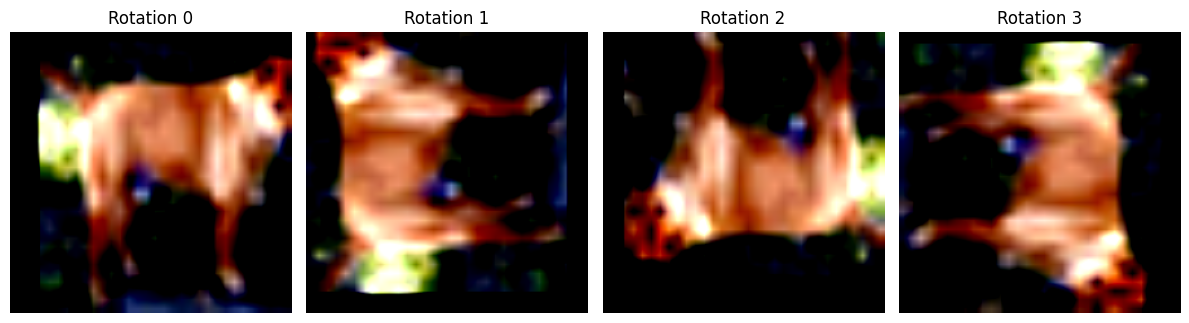

In [ ]:
# Get a single batch of images and labels from the dataloader
images, labels = next(iter(train_loader_sskd))

# Select the first sample (with its four rotated versions)
rotations = images[0]  # Shape: [4, 3, 32, 32]

# Plot all 4 rotations side by side
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for i in range(4):
    # Access each rotation
    rotated_image = rotations[i]  # Shape: [3, 32, 32]
    resized_image = resize(rotated_image, [224, 224])  # Shape: [3, 224, 224]

    # Convert to (H, W, C) format for visualization
    resized_image = resized_image.permute(1, 2, 0).numpy()

    # If normalization was applied during transforms, denormalize (adjust as needed)
    # mean = np.array([0.5, 0.5, 0.5])  # Example normalization mean
    # std = np.array([0.5, 0.5, 0.5])   # Example normalization std
    # resized_image = resized_image * std + mean

    resized_image = np.clip(resized_image, 0, 1)

    # Plot each rotation
    axes[i].imshow(resized_image)
    axes[i].set_title(f"Rotation {i}")
    axes[i].axis('off')

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.count = 0
        self.sum = 0.0
        self.val = 0.0
        self.avg = 0.0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

def norm(x):

    n = np.linalg.norm(x)
    return x / n


class wrapper(nn.Module):

    def __init__(self, module, is_resnet=False):

        super(wrapper, self).__init__()

        self.backbone = module
        self.is_resnet = is_resnet
        feat_dim = list(module.children())[-1].in_features
        self.proj_head = nn.Sequential(
            nn.Linear(feat_dim, feat_dim),
            nn.ReLU(inplace=True),
            nn.Linear(feat_dim, feat_dim)
            )

    def forward(self, x, bb_grad=True):

        # feats, out = self.backbone(x, is_feat=True)
        # feat = feats[-1].view(feats[-1].size(0), -1)

        out = self.backbone(x)
        if not self.is_resnet:
          for idx,(layer, fmap ) in enumerate(feature_maps.items()):
            # print(f"Feature map from {layer}: {fmap.shape}")
            if idx == len(feature_maps.items())-1:
              # print(f"Feature map from {layer}: {fmap.shape}")
              feat = fmap
              break
        else:
          for idx,(layer, fmap ) in enumerate(feature_maps_resnet.items()):
            # print(f"Feature map from {layer}: {fmap.shape}")
            if idx == len(feature_maps_resnet.items())-1:
                # print(f"Feature map from {layer}: {fmap.shape}")
                feat = fmap.squeeze(dim=2).squeeze(dim=2)
                break




        if not bb_grad:
            feat = feat.detach()

        return out, self.proj_head(feat), feat


In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, is_last=False):
        super(BasicBlock, self).__init__()
        self.is_last = is_last
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        preact = out
        out = F.relu(out)
        if self.is_last:
            return out, preact
        else:
            return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, is_last=False):
        super(Bottleneck, self).__init__()
        self.is_last = is_last
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        preact = out
        out = F.relu(out)
        if self.is_last:
            return out, preact
        else:
            return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def get_feat_modules(self):
        feat_m = nn.ModuleList([])
        feat_m.append(self.conv1)
        feat_m.append(self.bn1)
        feat_m.append(self.layer1)
        feat_m.append(self.layer2)
        feat_m.append(self.layer3)
        feat_m.append(self.layer4)
        return feat_m

    def get_bn_before_relu(self):
        if isinstance(self.layer1[0], Bottleneck):
            bn1 = self.layer1[-1].bn3
            bn2 = self.layer2[-1].bn3
            bn3 = self.layer3[-1].bn3
            bn4 = self.layer4[-1].bn3
        elif isinstance(self.layer1[0], BasicBlock):
            bn1 = self.layer1[-1].bn2
            bn2 = self.layer2[-1].bn2
            bn3 = self.layer3[-1].bn2
            bn4 = self.layer4[-1].bn2
        else:
            raise NotImplementedError('ResNet unknown block error !!!')

        return [bn1, bn2, bn3, bn4]

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for i in range(num_blocks):
            stride = strides[i]
            layers.append(block(self.in_planes, planes, stride, i == num_blocks - 1))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, is_feat=False, preact=False):
        out = F.relu(self.bn1(self.conv1(x)))
        f0 = out
        out, f1_pre = self.layer1(out)
        f1 = out
        out, f2_pre = self.layer2(out)
        f2 = out
        out, f3_pre = self.layer3(out)
        f3 = out
        out, f4_pre = self.layer4(out)
        f4 = out
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        f5 = out
        out = self.linear(out)
        if is_feat:
            if preact:
                return [[f0, f1_pre, f2_pre, f3_pre, f4_pre, f5], out]
            else:
                return [f0, f1, f2, f3, f4, f5], out
        else:
            return out


def ResNet18(**kwargs):
    return ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)


def ResNet34(**kwargs):
    return ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)


def ResNet50(**kwargs):
    return ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)


class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride, dropRate=0.0):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
        self.equalInOut = (in_planes == out_planes)
        self.convShortcut = (not self.equalInOut) and nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                               padding=0, bias=False) or None

    def forward(self, x):
        if not self.equalInOut:
            x = self.relu1(self.bn1(x))
        else:
            out = self.relu1(self.bn1(x))
        out = self.relu2(self.bn2(self.conv1(out if self.equalInOut else x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        out = self.conv2(out)
        return torch.add(x if self.equalInOut else self.convShortcut(x), out)


class NetworkBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, out_planes, block, stride, dropRate=0.0):
        super(NetworkBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, out_planes, nb_layers, stride, dropRate)

    def _make_layer(self, block, in_planes, out_planes, nb_layers, stride, dropRate):
        layers = []
        for i in range(nb_layers):
            layers.append(block(i == 0 and in_planes or out_planes, out_planes, i == 0 and stride or 1, dropRate))
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.layer(x)


class WideResNet(nn.Module):
    def __init__(self, depth, num_classes, widen_factor=1, dropRate=0.0):
        super(WideResNet, self).__init__()
        nChannels = [16, 16*widen_factor, 32*widen_factor, 64*widen_factor]
        assert (depth - 4) % 6 == 0, 'depth should be 6n+4'
        n = (depth - 4) // 6
        block = BasicBlock
        # 1st conv before any network block
        self.conv1 = nn.Conv2d(3, nChannels[0], kernel_size=3, stride=1,
                               padding=1, bias=False)
        # 1st block
        self.block1 = NetworkBlock(n, nChannels[0], nChannels[1], block, 1, dropRate)
        # 2nd block
        self.block2 = NetworkBlock(n, nChannels[1], nChannels[2], block, 2, dropRate)
        # 3rd block
        self.block3 = NetworkBlock(n, nChannels[2], nChannels[3], block, 2, dropRate)
        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(nChannels[3])
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(nChannels[3], num_classes)
        self.nChannels = nChannels[3]

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def get_feat_modules(self):
        feat_m = nn.ModuleList([])
        feat_m.append(self.conv1)
        feat_m.append(self.block1)
        feat_m.append(self.block2)
        feat_m.append(self.block3)
        return feat_m

    def get_bn_before_relu(self):
        bn1 = self.block2.layer[0].bn1
        bn2 = self.block3.layer[0].bn1
        bn3 = self.bn1

        return [bn1, bn2, bn3]

    # def forward(self, x, is_feat=False, preact=False):
    def forward(self, x, is_feat=False, preact=False):
        # Merge batch size and rotation dimensions: [batch_size, 4, 3, 32, 32] -> [batch_size*4, 3, 32, 32]
        # Merge batch size and rotation dimensions: [batch_size, 4, 3, 32, 32] -> [batch_size*4, 3, 32, 32]
        try:
            batch_size, rotations, channels, height, width = x.size()
            x = x.view(batch_size * rotations, channels, height, width)
        except:
          rotations = None

        out = self.conv1(x)
        f0 = out
        out = self.block1(out)
        f1 = out
        out = self.block2(out)
        f2 = out
        out = self.block3(out)
        f3 = out
        out = self.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(-1, self.nChannels)
        f4 = out

        # Aggregating predictions across rotations: average them
        if rotations is not None:
          out = out.view(batch_size, rotations, -1).mean(dim=1)  # shape [batch_size, num_classes]

        out = self.fc(out)

        if is_feat:
            if preact:
                f1 = self.block2.layer[0].bn1(f1)
                f2 = self.block3.layer[0].bn1(f2)
                f3 = self.bn1(f3)
            return [f0, f1, f2, f3, f4], out
        else:
            return out

        # out = self.conv1(x)
        # f0 = out
        # out = self.block1(out)
        # f1 = out
        # out = self.block2(out)
        # f2 = out
        # out = self.block3(out)
        # f3 = out
        # out = self.relu(self.bn1(out))
        # out = F.avg_pool2d(out, 8)
        # out = out.view(-1, self.nChannels)
        # f4 = out
        # out = self.fc(out)
        # if is_feat:
        #     if preact:
        #         f1 = self.block2.layer[0].bn1(f1)
        #         f2 = self.block3.layer[0].bn1(f2)
        #         f3 = self.bn1(f3)
        #     return [f0, f1, f2, f3, f4], out
        # else:
        #     return out


def wrn(**kwargs):
    """
    Constructs a Wide Residual Networks.
    """
    model = WideResNet(**kwargs)
    return model


def wrn_40_2(**kwargs):
    model = WideResNet(depth=40, widen_factor=2, **kwargs)
    return model


def wrn_40_1(**kwargs):
    model = WideResNet(depth=40, widen_factor=1, **kwargs)
    return model


def wrn_16_2(**kwargs):
    model = WideResNet(depth=16, widen_factor=2, **kwargs)
    return model


def wrn_16_1(**kwargs):
    model = WideResNet(depth=16, widen_factor=1, **kwargs)
    return model


feature_maps = {}

feature_maps_resnet = {}

# Hook function to save outputs
def hook_fn(module, input, output):
    feature_maps[module] = output

def hook_fn_resnet(module, input, output):
    feature_maps_resnet[module] = output


def create_unfreezed_models(num_classes=10):
    """Create a ViT model with a dynamic number of output classes."""
    model = create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes)
    #freeze all layers
    for param in model.parameters():
        param.requires_grad = False
    # print(model.named_children)
    model.patch_embed.register_forward_hook(hook_fn)  # For patch embedding output (f0)
    model.blocks[0].register_forward_hook(hook_fn)   # After first transformer block (f1)
    model.blocks[4].register_forward_hook(hook_fn)   # After fifth transformer block (f2)
    model.blocks[8].register_forward_hook(hook_fn)   # After ninth transformer block (f3)
    model.blocks[11].register_forward_hook(hook_fn)  # After final transformer block (f4)
    model.head_drop.register_forward_hook(hook_fn)
    model.head = torch.nn.Linear(model.head.in_features, num_classes)  # Replace the classifier head

    rmodel = resnet50(pretrained=True)
    # print(rmodel.named_children)
    num_features = rmodel.fc.in_features       # Get the number of input features of the last layer
    rmodel.fc = nn.Linear(num_features, num_classes)      # Replace the last fully connected layer with a new one with `num_classes` outputs

    rmodel.layer1.register_forward_hook(hook_fn_resnet)
    rmodel.layer2.register_forward_hook(hook_fn_resnet)
    rmodel.layer3.register_forward_hook(hook_fn_resnet)
    rmodel.layer4.register_forward_hook(hook_fn_resnet)
    rmodel.avgpool.register_forward_hook(hook_fn_resnet)
    return model, rmodel


tchr_unfreezed, stu_unfreezed = create_unfreezed_models()
model_dict = {
    'ResNet18': ResNet18,
    'ResNet34': ResNet34,
    'ResNet50': ResNet50,
    'wrn_40_2': wrn_40_2,
    'wrn_40_1': wrn_40_1,
    'wrn_16_2': wrn_16_2,
    'wrn_16_1': wrn_16_1,
    'pretrained_resnet': stu_unfreezed,
    'pretrained_vit': tchr_unfreezed
}


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
list(model_dict['pretrained_resnet'].children())[-1].in_features

2048

In [ ]:
inputs = torch.randn(1, 3, 224, 224)  # Example input
outputs = model_dict['pretrained_vit'](inputs)
# Print feature maps
for idx,(layer, fmap ) in enumerate(feature_maps.items()):
    # print(f"Feature map from {layer}: {fmap.shape}")
    # if idx == len(feature_maps.items())-1:
      print(f"Feature map from layer: {fmap.shape}")

outputs = model_dict['pretrained_resnet'](inputs)
# Print feature maps
for idx,(layer, fmap ) in enumerate(feature_maps_resnet.items()):
    # print(f"Feature map from {layer}: {fmap.shape}")
    # if idx == len(feature_maps_resnet.items())-1:
      print(f"Feature map from layer: {fmap.shape}")
      # reduced_tensor = fmap.squeeze(dim=2).squeeze(dim=2)
      # print(reduced_tensor.shape)

Feature map from layer: torch.Size([1, 196, 768])
Feature map from layer: torch.Size([1, 197, 768])
Feature map from layer: torch.Size([1, 197, 768])
Feature map from layer: torch.Size([1, 197, 768])
Feature map from layer: torch.Size([1, 197, 768])
Feature map from layer: torch.Size([1, 768])
Feature map from layer: torch.Size([1, 256, 56, 56])
Feature map from layer: torch.Size([1, 512, 28, 28])
Feature map from layer: torch.Size([1, 1024, 14, 14])
Feature map from layer: torch.Size([1, 2048, 7, 7])
Feature map from layer: torch.Size([1, 2048, 1, 1])


In [ ]:
feature_maps, feature_maps_resnet = {} , {}

In [ ]:
import shutil
shutil.rmtree('/content/experiments')

In [ ]:
import time
import os.path as osp
import torch.optim as optim
from tensorboardX import SummaryWriter
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import MultiStepLR

args = {
    'epoch': 5,
    'batch_size': 64,
    'lr': 0.05,
    'momentum': 0.9,
    'weight_decay': 5e-4,
    'gamma': 0.1,
    'milestones': [150, 180, 210],
    'save_interval':5,
    # 'arch': 'wrn_40_2',
    'arch': 'pretrained_vit',
    'seed': 0,
    'gpu_id': 0
}

torch.backends.cudnn.benchmark = True

# torch.manual_seed(args.seed)
# torch.cuda.manual_seed(args.seed)
# np.random.seed(args.seed)
# os.environ['CUDA_VISIBLE_DEVICES'] = str(args.gpu_id)

exp_name = 'teacher_{}_seed{}'.format(args['arch'], args['seed'])
exp_path = './experiments/{}'.format(exp_name)
os.makedirs(exp_path, exist_ok=True)

# transform_train = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5071, 0.4866, 0.4409], std=[0.2675, 0.2565, 0.2761]),
# ])

# model = model_dict[args['arch']](num_classes=10).cuda()
# model = model_dict[args['arch']].cuda()
model = model_dict[args['arch']].to(device)
optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'], weight_decay=args['weight_decay'])
scheduler = MultiStepLR(optimizer, milestones=args['milestones'], gamma=args['gamma'])

logger = SummaryWriter(osp.join(exp_path, 'events'))
best_acc = -1
for epoch in range(args['epoch']):

    model.train()
    loss_record = AverageMeter()
    acc_record = AverageMeter()

    start = time.time()

    for batch_idx,(x, target) in enumerate(train_loader_sskd):

        optimizer.zero_grad()
        x = x.to(device)
        target = target.to(device)
        # x = x.cuda()
        # target = target.cuda()

        # batch_size, rotations, channels, height, width = x.size()
        # x = x.view(batch_size * rotations, channels, height, width)
        rand_idx = random.randint(0, 3)
        x = x[:,rand_idx,:,:,:]
        x  = resize(x, [224, 224])
        if x.shape != torch.Size([64, 3, 224, 224]):
          print(x.shape, type(x))
          continue

        output = model(x)
        loss = F.cross_entropy(output, target)

        loss.backward()
        optimizer.step()

        batch_acc = accuracy(output, target, topk=(1,))[0]
        loss_record.update(loss.item(), x.size(0))
        acc_record.update(batch_acc.item(), x.size(0))

        if batch_idx % 100 == 0:
            print("Batch index ", batch_idx, "/", len(train_loader_sskd.dataset)/64, "loss", loss.item(), "acc", batch_acc.item())

    logger.add_scalar('train/cls_loss', loss_record.avg, epoch+1)
    logger.add_scalar('train/cls_acc', acc_record.avg, epoch+1)

    run_time = time.time() - start

    info = 'train_Epoch:{:03d}/{:03d}\t run_time:{:.3f}\t cls_loss:{:.3f}\t cls_acc:{:.2f}\t'.format(
        epoch+1, args['epoch'], run_time, loss_record.avg, acc_record.avg)
    print(info)

    model.eval()
    acc_record = AverageMeter()
    loss_record = AverageMeter()
    start = time.time()
    for x, target in val_loader_sskd:

        # x = x.cuda()
        x = x.to(device)
        rand_idx = random.randint(0, 3)
        x = x[:,rand_idx,:,:,:]
        x  = resize(x, [224, 224])
        if x.shape != torch.Size([64, 3, 224, 224]):
          print(x.shape, type(x))
          continue

        # target = target.cuda()
        target = target.to(device)
        with torch.no_grad():
            output = model(x)
            loss = F.cross_entropy(output, target)

        batch_acc = accuracy(output, target, topk=(1,))[0]
        loss_record.update(loss.item(), x.size(0))
        acc_record.update(batch_acc.item(), x.size(0))

    run_time = time.time() - start

    logger.add_scalar('val/cls_loss', loss_record.avg, epoch+1)
    logger.add_scalar('val/cls_acc', acc_record.avg, epoch+1)

    info = 'test_Epoch:{:03d}/{:03d}\t run_time:{:.2f}\t cls_loss:{:.3f}\t cls_acc:{:.2f}\n'.format(
            epoch+1, args['epoch'], run_time, loss_record.avg, acc_record.avg)
    print(info)

    scheduler.step()

    # save checkpoint
    if (epoch+1) in args['milestones'] or epoch+1==args['epoch'] or (epoch+1)%args['save_interval']==0:
        state_dict = dict(epoch=epoch+1, state_dict=model.state_dict(), acc=acc_record.avg)
        name = osp.join(exp_path, 'ckpt/{:03d}.pth'.format(epoch+1))
        os.makedirs(osp.dirname(name), exist_ok=True)
        torch.save(state_dict, name)

    # save best
    if acc_record.avg > best_acc:
        state_dict = dict(epoch=epoch+1, state_dict=model.state_dict(), acc=acc_record.avg)
        name = osp.join(exp_path, 'ckpt/best.pth')
        os.makedirs(osp.dirname(name), exist_ok=True)
        torch.save(state_dict, name)
        best_acc = acc_record.avg


print('best_acc: {:.2f}'.format(best_acc))

Batch index  0 / 781.25 loss 2.0838470458984375 acc 78.125
Batch index  100 / 781.25 loss 1.0213160514831543 acc 90.625
Batch index  200 / 781.25 loss 6.694136142730713 acc 70.3125
Batch index  300 / 781.25 loss 2.6847169399261475 acc 84.375
Batch index  400 / 781.25 loss 5.381159782409668 acc 68.75
Batch index  500 / 781.25 loss 3.327500343322754 acc 73.4375
Batch index  600 / 781.25 loss 5.612051963806152 acc 71.875
Batch index  700 / 781.25 loss 3.2945010662078857 acc 79.6875
torch.Size([16, 3, 224, 224]) <class 'torch.Tensor'>
train_Epoch:001/005	 run_time:766.632	 cls_loss:3.779	 cls_acc:75.34	
torch.Size([16, 3, 224, 224]) <class 'torch.Tensor'>
test_Epoch:001/005	 run_time:151.24	 cls_loss:3.596	 cls_acc:77.49

best_acc: 77.49


In [ ]:
t_model.named_modules

<bound method Module.named_modules of wrapper(
  (backbone): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (drop1): Dropout(p=0.0, inplace=False)
          (norm): Identity()
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop2): Dropout(p=0.0, inplace=False)
        )
        (ls2): Identity()
        (drop_path2): Identity()
      )
      (1): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (drop1): Dropout(p=0.0, inplace=False)
          (norm): Identity()
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop2): Dropout(p=0.0, inplace=False)
        )
        (ls2): Identity()
        (drop_path2): Identity()
      )
      (2): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (drop1): Dropout(p=0.0, inplace=False)
          (norm): Identity()
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop2): Dropout(p=0.0, inplace=False)
        )
        (ls2): Identity()
        (drop_path2): Identity()
      )
      (3): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (drop1): Dropout(p=0.0, inplace

In [ ]:
from ast import Break
torch.backends.cudnn.benchmark = True

args = {
    'epoch': 3,
    't_epoch': 1,
    'batch_size': 64,
    'lr': 0.05,
    't_lr': 0.05,
    'momentum': 0.9,
    'weight_decay': 5e-4,
    'gamma': 0.1,
    'milestones': [150, 180, 210],
    't_milestones': [30, 45],
    'save_interval': 10,
    'ce_weight': 0.1,
    'kd_weight': 0.9,
    'tf_weight': 2.7,
    'ss_weight': 10.0,
    'kd_T': 4.0,
    'tf_T': 4.0,
    'ss_T': 0.5,
    'ratio_tf': 1.0,
    'ratio_ss': 0.75,
    # 's_arch': 'wrn_16_2',
    # 't_path': '/content/experiments/teacher_wrn_40_2_seed0/',
    's_arch': 'pretrained_resnet',
    't_path': '/content/experiments/teacher_pretrained_vit_seed0/',
    'seed': 0,
    'gpu_id': 0
}

# torch.manual_seed(argsseed)
# torch.cuda.manual_seed(args.seed)
# np.random.seed(args.seed)
# os.environ['CUDA_VISIBLE_DEVICES'] = str(args.gpu_id)

t_name = osp.abspath(args['t_path']).split('/')[-1]
t_arch = '_'.join(t_name.split('_')[1:-1])
exp_name = 'sskd_student_{}_weight{}+{}+{}+{}_T{}+{}+{}_ratio{}+{}_seed{}_{}'.format(\
            args['s_arch'], \
            args['ce_weight'], args['kd_weight'], args['tf_weight'], args['ss_weight'], \
            args['kd_T'], args['tf_T'], args['ss_T'], \
            args['ratio_tf'], args['ratio_ss'], \
            args['seed'], t_name)
exp_path = './experiments/{}'.format(exp_name)
os.makedirs(exp_path, exist_ok=True)


ckpt_path = osp.join(args['t_path'], 'ckpt/best.pth')
# t_model = model_dict[t_arch](num_classes=10).cuda()
t_model = model_dict[t_arch].to(device)
state_dict = torch.load(ckpt_path)['state_dict']
t_model.load_state_dict(state_dict)
#freeze backbone
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the classifier (usually the head of the model)
for param in model.head.parameters():
    param.requires_grad = True


t_model = wrapper(module=t_model).to(device)

t_optimizer = optim.SGD([{'params':t_model.backbone.parameters(), 'lr':0.0},
                        {'params':t_model.proj_head.parameters(), 'lr':args['t_lr']}],
                        momentum=args['momentum'], weight_decay=args['weight_decay'])


t_model.eval()
t_scheduler = MultiStepLR(t_optimizer, milestones=args['t_milestones'], gamma=args['gamma'])

logger = SummaryWriter(osp.join(exp_path, 'events'))

# acc_record = AverageMeter()
# loss_record = AverageMeter()
# start = time.time()
# for x, target in val_loader_sskd:

#     break ##################################################### REMOVE ############################
#     rand_idx = random.randint(0, 3)
#     x = x[:,rand_idx,:,:,:].to(device)
#     x  = resize(x, [224, 224])
#     if x.shape != torch.Size([64, 3, 224, 224]): #batch idx error
#       print(x.shape, type(x))
#       continue

#     # print(x.shape)
#     target = target.to(device)
#     with torch.no_grad():
#         output, _, feat = t_model(x)
#         loss = F.cross_entropy(output, target)

#     batch_acc = accuracy(output, target, topk=(1,))[0]
#     acc_record.update(batch_acc.item(), x.size(0))
#     loss_record.update(loss.item(), x.size(0))

# run_time = time.time() - start
# info = 'teacher cls_acc:{:.2f}\n'.format(acc_record.avg)
# print(info)

# train ssp_head
for epoch in range(args['t_epoch']):

    t_model.eval()
    loss_record = AverageMeter()
    acc_record = AverageMeter()

    start = time.time()
    for batch_idx,(x, _) in enumerate(train_loader_sskd):

        # break  ##################################################### REMOVE ###########################

        t_optimizer.zero_grad()

        x = x.to(device)
        c,h,w = x.size()[-3:]
        x = x.view(-1, c, h, w)
        x  = resize(x, [224, 224])
        if x.shape != torch.Size([256, 3, 224, 224]):
          print(x.shape, type(x))
          continue
        # print("Training tchr",x.shape)

        _, rep, feat = t_model(x, bb_grad=False)
        batch = int(x.size(0) / 4)
        nor_index = (torch.arange(4*batch) % 4 == 0).to(device)
        aug_index = (torch.arange(4*batch) % 4 != 0).to(device)

        nor_rep = rep[nor_index]
        aug_rep = rep[aug_index]
        nor_rep = nor_rep.unsqueeze(2).expand(-1,-1,3*batch).transpose(0,2)
        aug_rep = aug_rep.unsqueeze(2).expand(-1,-1,1*batch)
        simi = F.cosine_similarity(aug_rep, nor_rep, dim=1)
        target = torch.arange(batch).unsqueeze(1).expand(-1,3).contiguous().view(-1).long().to(device)
        loss = F.cross_entropy(simi, target)

        loss.backward()
        t_optimizer.step()

        batch_acc = accuracy(simi, target, topk=(1,))[0]
        loss_record.update(loss.item(), 3*batch)
        acc_record.update(batch_acc.item(), 3*batch)

        if batch_idx % 10 == 0:
            print("Batch index ", batch_idx, "/", len(train_loader_sskd.dataset)/64, "loss", loss.item(), "acc", batch_acc.item())

    logger.add_scalar('train/teacher_ssp_loss', loss_record.avg, epoch+1)
    logger.add_scalar('train/teacher_ssp_acc', acc_record.avg, epoch+1)

    run_time = time.time() - start
    info = 'teacher_train_Epoch:{:03d}/{:03d}\t run_time:{:.3f}\t ssp_loss:{:.3f}\t ssp_acc:{:.2f}\t'.format(
        epoch+1, args['t_epoch'], run_time, loss_record.avg, acc_record.avg)
    print(info)

    # t_model.eval()
    # acc_record = AverageMeter()
    # loss_record = AverageMeter()
    # start = time.time()
    # for batch_idx(x, _) in enumerate(val_loader_sskd):
    #     # break ##################################################### REMOVE ############################
    #     x = x.to(device)
    #     c,h,w = x.size()[-3:]
    #     x = x.view(-1, c, h, w)
    #     x = resize(x, [224, 224])
    #     if x.shape != torch.Size([256, 3, 224, 224]):
    #       print(x.shape, type(x))
    #       continue

    #     with torch.no_grad():
    #         _, rep, feat = t_model(x)
    #     batch = int(x.size(0) / 4)
    #     nor_index = (torch.arange(4*batch) % 4 == 0).to(device)
    #     aug_index = (torch.arange(4*batch) % 4 != 0).to(device)

    #     nor_rep = rep[nor_index]
    #     aug_rep = rep[aug_index]
    #     nor_rep = nor_rep.unsqueeze(2).expand(-1,-1,3*batch).transpose(0,2)
    #     aug_rep = aug_rep.unsqueeze(2).expand(-1,-1,1*batch)
    #     simi = F.cosine_similarity(aug_rep, nor_rep, dim=1)
    #     target = torch.arange(batch).unsqueeze(1).expand(-1,3).contiguous().view(-1).long().to(device)
    #     loss = F.cross_entropy(simi, target)

    #     batch_acc = accuracy(simi, target, topk=(1,))[0]
    #     acc_record.update(batch_acc.item(),3*batch)
    #     loss_record.update(loss.item(), 3*batch)

    #     if batch_idx % 100 == 0:
    #         print("Batch index ", batch_idx, "/", len(train_loader_sskd.dataset)/64, "loss", loss.item(), "acc", batch_acc.item())

    # run_time = time.time() - start
    # logger.add_scalar('val/teacher_ssp_loss', loss_record.avg, epoch+1)
    # logger.add_scalar('val/teacher_ssp_acc', acc_record.avg, epoch+1)

    # info = 'ssp_test_Epoch:{:03d}/{:03d}\t run_time:{:.2f}\t ssp_loss:{:.3f}\t ssp_acc:{:.2f}\n'.format(
    #         epoch+1, args['t_epoch'], run_time, loss_record.avg, acc_record.avg)
    # print(info)
    # break ##################################################### REMOVE ############################

    t_scheduler.step()



name = osp.join(exp_path, 'ckpt/teacher.pth')
os.makedirs(osp.dirname(name), exist_ok=True)
torch.save(t_model.state_dict(), name)


# s_model = model_dict[args['s_arch']](num_classes=10)
s_model = model_dict[args['s_arch']]
s_model = wrapper(module=s_model, is_resnet=True).to(device)
optimizer = optim.SGD(s_model.parameters(), lr=args['lr'], momentum=args['momentum'], weight_decay=args['weight_decay'])
scheduler = MultiStepLR(optimizer, milestones=args['milestones'], gamma=args['gamma'])

best_acc = 0
for epoch in range(args['epoch']):

    # train
    s_model.train()
    loss1_record = AverageMeter()
    loss2_record = AverageMeter()
    loss3_record = AverageMeter()
    loss4_record = AverageMeter()
    cls_acc_record = AverageMeter()
    ssp_acc_record = AverageMeter()

    start = time.time()
    for batch_idx,(x, target) in enumerate(train_loader_sskd):

        # if batch_idx>0:  ##################################################### REMOVE ############################
        #   continue
        optimizer.zero_grad()

        c,h,w = x.size()[-3:]
        x = x.view(-1,c,h,w).to(device)
        target = target.to(device)
        x = resize(x, [224, 224])
        if x.shape != torch.Size([256, 3, 224, 224]):
          print(x.shape, type(x))
          continue

        batch = int(x.size(0) / 4)
        nor_index = (torch.arange(4*batch) % 4 == 0).to(device)
        aug_index = (torch.arange(4*batch) % 4 != 0).to(device)

        output, s_feat, _ = s_model(x, bb_grad=True)
        log_nor_output = F.log_softmax(output[nor_index] / args['kd_T'], dim=1)
        log_aug_output = F.log_softmax(output[aug_index] / args['tf_T'], dim=1)
        with torch.no_grad():
            knowledge, t_feat, _ = t_model(x)
            nor_knowledge = F.softmax(knowledge[nor_index] / args['kd_T'], dim=1)
            aug_knowledge = F.softmax(knowledge[aug_index] / args['tf_T'], dim=1)

        # error level ranking
        aug_target = target.unsqueeze(1).expand(-1,3).contiguous().view(-1).long().to(device)
        rank = torch.argsort(aug_knowledge, dim=1, descending=True)
        rank = torch.argmax(torch.eq(rank, aug_target.unsqueeze(1)).long(), dim=1)  # groundtruth label's rank
        index = torch.argsort(rank)
        tmp = torch.nonzero(rank, as_tuple=True)[0]
        wrong_num = tmp.numel()
        correct_num = 3*batch - wrong_num
        wrong_keep = int(wrong_num * args['ratio_tf'])
        index = index[:correct_num+wrong_keep]
        distill_index_tf = torch.sort(index)[0]

        s_nor_feat = s_feat[nor_index]
        s_aug_feat = s_feat[aug_index]
        s_nor_feat = s_nor_feat.unsqueeze(2).expand(-1,-1,3*batch).transpose(0,2)
        s_aug_feat = s_aug_feat.unsqueeze(2).expand(-1,-1,1*batch)
        s_simi = F.cosine_similarity(s_aug_feat, s_nor_feat, dim=1)

        t_nor_feat = t_feat[nor_index]
        t_aug_feat = t_feat[aug_index]
        t_nor_feat = t_nor_feat.unsqueeze(2).expand(-1,-1,3*batch).transpose(0,2)
        t_aug_feat = t_aug_feat.unsqueeze(2).expand(-1,-1,1*batch)
        t_simi = F.cosine_similarity(t_aug_feat, t_nor_feat, dim=1)

        t_simi = t_simi.detach()
        aug_target = torch.arange(batch).unsqueeze(1).expand(-1,3).contiguous().view(-1).long().to(device)
        rank = torch.argsort(t_simi, dim=1, descending=True)
        rank = torch.argmax(torch.eq(rank, aug_target.unsqueeze(1)).long(), dim=1)  # groundtruth label's rank
        index = torch.argsort(rank)
        tmp = torch.nonzero(rank, as_tuple=True)[0]
        wrong_num = tmp.numel()
        correct_num = 3*batch - wrong_num
        wrong_keep = int(wrong_num * args['ratio_ss'])
        index = index[:correct_num+wrong_keep]
        distill_index_ss = torch.sort(index)[0]

        log_simi = F.log_softmax(s_simi / args['ss_T'], dim=1)
        simi_knowledge = F.softmax(t_simi / args['ss_T'], dim=1)

        loss1 = F.cross_entropy(output[nor_index], target)
        loss2 = F.kl_div(log_nor_output, nor_knowledge, reduction='batchmean') * args['kd_T'] * args['kd_T']
        loss3 = F.kl_div(log_aug_output[distill_index_tf], aug_knowledge[distill_index_tf], \
                        reduction='batchmean') * args['tf_T'] * args['tf_T']
        loss4 = F.kl_div(log_simi[distill_index_ss], simi_knowledge[distill_index_ss], \
                        reduction='batchmean') * args['ss_T'] * args['ss_T']

        loss = args['ce_weight'] * loss1 + args['kd_weight'] * loss2 + args['tf_weight'] * loss3 + args['ss_weight'] * loss4

        loss.backward()
        optimizer.step()

        cls_batch_acc = accuracy(output[nor_index], target, topk=(1,))[0]
        ssp_batch_acc = accuracy(s_simi, aug_target, topk=(1,))[0]
        loss1_record.update(loss1.item(), batch)
        loss2_record.update(loss2.item(), batch)
        loss3_record.update(loss3.item(), len(distill_index_tf))
        loss4_record.update(loss4.item(), len(distill_index_ss))
        cls_acc_record.update(cls_batch_acc.item(), batch)
        ssp_acc_record.update(ssp_batch_acc.item(), 3*batch)

        if batch_idx % 10 == 0:
            print("Batch index ", batch_idx, "/", len(train_loader_sskd.dataset)/64, f"loss1  {loss1.item():.2f} , loss2 , {loss2.item():.2f} loss3  {loss3.item():.2f} loss4  {loss4.item():.2f} cls_acc {cls_batch_acc.item():.2f} ssp_acc {ssp_batch_acc.item():.2f}")

    logger.add_scalar('train/ce_loss', loss1_record.avg, epoch+1)
    logger.add_scalar('train/kd_loss', loss2_record.avg, epoch+1)
    logger.add_scalar('train/tf_loss', loss3_record.avg, epoch+1)
    logger.add_scalar('train/ss_loss', loss4_record.avg, epoch+1)
    logger.add_scalar('train/cls_acc', cls_acc_record.avg, epoch+1)
    logger.add_scalar('train/ss_acc', ssp_acc_record.avg, epoch+1)

    run_time = time.time() - start
    info = 'student_train_Epoch:{:03d}/{:03d}\t run_time:{:.3f}\t ce_loss:{:.3f}\t kd_loss:{:.3f}\t cls_acc:{:.2f}'.format(
        epoch+1, args['epoch'], run_time, loss1_record.avg, loss2_record.avg, cls_acc_record.avg)
    print(info)

    # cls val
    # s_model.eval()
    # acc_record = AverageMeter()
    # loss_record = AverageMeter()
    # start = time.time()
    # for batch_idx,( x, target) in enumerate(val_loader_sskd):

    #     # break  ##################################################### REMOVE ############################

    #     x = x[:,0,:,:,:].to(device)
    #     x  = resize(x, [224, 224])
    #     if x.shape != torch.Size([64, 3, 224, 224]): #batch idx error
    #       print(x.shape, type(x))
    #       continue
    #     target = target.to(device)
    #     with torch.no_grad():
    #         output, _, feat = s_model(x)
    #         loss = F.cross_entropy(output, target)

    #     batch_acc = accuracy(output, target, topk=(1,))[0]
    #     acc_record.update(batch_acc.item(), x.size(0))
    #     loss_record.update(loss.item(), x.size(0))

    #     if batch_idx % 100 == 0:
    #         print("Batch index ", batch_idx, "/", len(val_loader_sskd.dataset)/64, "loss", loss.item(), "acc", batch_acc.item())

    # run_time = time.time() - start
    # logger.add_scalar('val/ce_loss', loss_record.avg, epoch+1)
    # logger.add_scalar('val/cls_acc', acc_record.avg, epoch+1)

    # info = 'student_test_Epoch:{:03d}/{:03d}\t run_time:{:.2f}\t cls_acc:{:.2f}\n'.format(
    #         epoch+1, args['epoch'], run_time, acc_record.avg)
    # print(info)

    if acc_record.avg > best_acc:
        best_acc = acc_record.avg
        state_dict = dict(epoch=epoch+1, state_dict=s_model.state_dict(), best_acc=best_acc)
        name = osp.join(exp_path, 'ckpt/student_best.pth')
        os.makedirs(osp.dirname(name), exist_ok=True)
        torch.save(state_dict, name)

    # break  ##################################################### REMOVE ############################
    scheduler.step()

<ipython-input-56-fe488b2a9c03>:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ckpt_path)['state_dict']


Batch index  0 / 781.25 loss 4.005918979644775 acc 58.33333206176758
Batch index  10 / 781.25 loss 3.6988160610198975 acc 69.27082824707031
Batch index  20 / 781.25 loss 3.6000945568084717 acc 58.33333206176758
Batch index  30 / 781.25 loss 3.560849905014038 acc 60.416664123535156
Batch index  40 / 781.25 loss 3.5226316452026367 acc 62.499996185302734
Batch index  50 / 781.25 loss 3.47493052482605 acc 65.10416412353516
Batch index  60 / 781.25 loss 3.4603140354156494 acc 68.75
Batch index  70 / 781.25 loss 3.4399802684783936 acc 66.14582824707031
Batch index  80 / 781.25 loss 3.445204973220825 acc 69.79166412353516
Batch index  90 / 781.25 loss 3.4376108646392822 acc 59.89583206176758
Batch index  100 / 781.25 loss 3.4068078994750977 acc 68.22916412353516
Batch index  110 / 781.25 loss 3.4201385974884033 acc 66.66666412353516
Batch index  120 / 781.25 loss 3.4152889251708984 acc 68.75
Batch index  130 / 781.25 loss 3.39373779296875 acc 78.64582824707031
Batch index  140 / 781.25 loss 3

KeyboardInterrupt: 

In [ ]:
# 1hr55min for teacher epoch
# 2 hrs for 240/780 in epoch1 studentwe

# Evaluating Accuracies for all models

In [ ]:
loaders = [slic_loader, shapes_loader, noised_loader, scrambled_loader, texture_bias_loader,test_loader]
titles = ['SuperPixelated', 'Shapes', 'Noised', 'Scrambled', 'Texture','Normal']

In [ ]:
teacher_accs = []
for loader,title in zip(loaders,titles):
  this_loader_acc = evaluate_model(teacher_model, loader,device)
  teacher_accs.append(this_loader_acc)
  print(f"Teacher got {this_loader_acc} for {title} dataset")
print(teacher_accs)

Evaluating the model
Batch 1/157 - Accuracy: 9.38%
Batch 11/157 - Accuracy: 12.22%
Batch 21/157 - Accuracy: 10.19%
Batch 31/157 - Accuracy: 9.73%
Batch 41/157 - Accuracy: 10.44%
Batch 51/157 - Accuracy: 10.45%
Batch 61/157 - Accuracy: 10.53%
Batch 71/157 - Accuracy: 10.43%
Batch 81/157 - Accuracy: 10.71%
Batch 91/157 - Accuracy: 10.30%
Batch 101/157 - Accuracy: 10.09%
Batch 111/157 - Accuracy: 10.14%
Batch 121/157 - Accuracy: 10.21%
Batch 131/157 - Accuracy: 10.16%
Batch 141/157 - Accuracy: 10.25%
Batch 151/157 - Accuracy: 10.15%
skipping last batch of size 16 --- gives shape error
Final Accuracy: 10.01%
Teacher got 0.10006009615384616 for SuperPixelated dataset
Evaluating the model
Batch 1/157 - Accuracy: 12.50%
Batch 11/157 - Accuracy: 10.09%
Batch 21/157 - Accuracy: 11.38%
Batch 31/157 - Accuracy: 10.99%
Batch 41/157 - Accuracy: 10.79%
Batch 51/157 - Accuracy: 10.88%
Batch 61/157 - Accuracy: 10.91%
Batch 71/157 - Accuracy: 10.76%
Batch 81/157 - Accuracy: 10.86%
Batch 91/157 - Accura

<ipython-input-64-49e864c20c1a>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image = torch.load(self.image_paths[idx])  # Assuming saved as .pt tensor files


Batch 1/157 - Accuracy: 71.88%
Batch 11/157 - Accuracy: 74.15%
Batch 21/157 - Accuracy: 70.46%
Batch 31/157 - Accuracy: 69.96%
Batch 41/157 - Accuracy: 70.27%
Batch 51/157 - Accuracy: 69.76%
Batch 61/157 - Accuracy: 69.44%
Batch 71/157 - Accuracy: 69.45%
Batch 81/157 - Accuracy: 69.56%
Batch 91/157 - Accuracy: 69.44%
Batch 101/157 - Accuracy: 69.59%
Batch 111/157 - Accuracy: 69.52%
Batch 121/157 - Accuracy: 69.63%
Batch 131/157 - Accuracy: 69.67%
Batch 141/157 - Accuracy: 69.86%
Batch 151/157 - Accuracy: 69.88%
skipping last batch of size 16 --- gives shape error
Final Accuracy: 69.71%
Teacher got 0.6971153846153846 for Noised dataset
Evaluating the model
Batch 1/157 - Accuracy: 7.81%
Batch 11/157 - Accuracy: 14.49%
Batch 21/157 - Accuracy: 15.40%
Batch 31/157 - Accuracy: 15.47%
Batch 41/157 - Accuracy: 15.09%
Batch 51/157 - Accuracy: 14.95%
Batch 61/157 - Accuracy: 14.96%
Batch 71/157 - Accuracy: 15.03%
Batch 81/157 - Accuracy: 15.12%
Batch 91/157 - Accuracy: 15.01%
Batch 101/157 - Ac

In [ ]:
indep_accs = []
for loader,title in zip(loaders,titles):
  this_loader_acc = evaluate_model(student_indep, loader, device)
  indep_accs.append(this_loader_acc)
  print(f"Independent Student got {this_loader_acc} for {title} dataset")
print(indep_accs)

Evaluating the model
Batch 1/157 - Accuracy: 10.94%
Batch 11/157 - Accuracy: 7.95%
Batch 21/157 - Accuracy: 9.52%
Batch 31/157 - Accuracy: 9.53%
Batch 41/157 - Accuracy: 9.53%
Batch 51/157 - Accuracy: 9.34%
Batch 61/157 - Accuracy: 9.45%
Batch 71/157 - Accuracy: 9.75%
Batch 81/157 - Accuracy: 9.72%
Batch 91/157 - Accuracy: 9.63%
Batch 101/157 - Accuracy: 9.82%
Batch 111/157 - Accuracy: 9.90%
Batch 121/157 - Accuracy: 9.94%
Batch 131/157 - Accuracy: 9.92%
Batch 141/157 - Accuracy: 9.75%
Batch 151/157 - Accuracy: 9.77%
skipping last batch of size 16 --- gives shape error
Final Accuracy: 9.87%
Independent Student got 0.09865785256410256 for SuperPixelated dataset
Evaluating the model
Batch 1/157 - Accuracy: 12.50%
Batch 11/157 - Accuracy: 7.95%
Batch 21/157 - Accuracy: 9.08%
Batch 31/157 - Accuracy: 9.78%
Batch 41/157 - Accuracy: 9.49%
Batch 51/157 - Accuracy: 9.22%
Batch 61/157 - Accuracy: 9.07%
Batch 71/157 - Accuracy: 9.18%
Batch 81/157 - Accuracy: 9.38%
Batch 91/157 - Accuracy: 9.50%


<ipython-input-64-49e864c20c1a>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image = torch.load(self.image_paths[idx])  # Assuming saved as .pt tensor files


Batch 1/157 - Accuracy: 45.31%
Batch 11/157 - Accuracy: 38.21%
Batch 21/157 - Accuracy: 38.76%
Batch 31/157 - Accuracy: 38.41%
Batch 41/157 - Accuracy: 38.49%
Batch 51/157 - Accuracy: 38.24%
Batch 61/157 - Accuracy: 38.42%
Batch 71/157 - Accuracy: 38.58%
Batch 81/157 - Accuracy: 38.60%
Batch 91/157 - Accuracy: 38.43%
Batch 101/157 - Accuracy: 38.10%
Batch 111/157 - Accuracy: 38.43%
Batch 121/157 - Accuracy: 38.31%
Batch 131/157 - Accuracy: 38.22%
Batch 141/157 - Accuracy: 38.03%
Batch 151/157 - Accuracy: 38.04%
skipping last batch of size 16 --- gives shape error
Final Accuracy: 37.93%
Independent Student got 0.379306891025641 for Noised dataset
Evaluating the model
Batch 1/157 - Accuracy: 9.38%
Batch 11/157 - Accuracy: 10.80%
Batch 21/157 - Accuracy: 11.01%
Batch 31/157 - Accuracy: 11.04%
Batch 41/157 - Accuracy: 11.24%
Batch 51/157 - Accuracy: 11.03%
Batch 61/157 - Accuracy: 11.63%
Batch 71/157 - Accuracy: 11.66%
Batch 81/157 - Accuracy: 11.55%
Batch 91/157 - Accuracy: 11.71%
Batch 1

In [ ]:
lm_accs = []
for loader,title in zip(loaders,titles):
  this_loader_acc = evaluate_model(student_lm, loader, device)
  lm_accs.append(this_loader_acc)
  print(f"LM Student got {this_loader_acc} for {title} dataset")
print(lm_accs)

Evaluating the model
Batch 1/157 - Accuracy: 6.25%
Batch 11/157 - Accuracy: 7.95%
Batch 21/157 - Accuracy: 9.30%
Batch 31/157 - Accuracy: 9.22%
Batch 41/157 - Accuracy: 9.68%
Batch 51/157 - Accuracy: 9.99%
Batch 61/157 - Accuracy: 9.61%
Batch 71/157 - Accuracy: 9.68%
Batch 81/157 - Accuracy: 9.70%
Batch 91/157 - Accuracy: 9.75%
Batch 101/157 - Accuracy: 9.65%
Batch 111/157 - Accuracy: 9.67%
Batch 121/157 - Accuracy: 9.53%
Batch 131/157 - Accuracy: 9.55%
Batch 141/157 - Accuracy: 9.62%
Batch 151/157 - Accuracy: 9.62%
skipping last batch of size 16 --- gives shape error
Final Accuracy: 9.62%
LM Student got 0.09615384615384616 for SuperPixelated dataset
Evaluating the model
Batch 1/157 - Accuracy: 7.81%
Batch 11/157 - Accuracy: 9.66%
Batch 21/157 - Accuracy: 10.42%
Batch 31/157 - Accuracy: 10.38%
Batch 41/157 - Accuracy: 9.76%
Batch 51/157 - Accuracy: 9.99%
Batch 61/157 - Accuracy: 10.14%
Batch 71/157 - Accuracy: 9.97%
Batch 81/157 - Accuracy: 9.97%
Batch 91/157 - Accuracy: 10.16%
Batch 1

<ipython-input-64-49e864c20c1a>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image = torch.load(self.image_paths[idx])  # Assuming saved as .pt tensor files


Batch 1/157 - Accuracy: 46.88%
Batch 11/157 - Accuracy: 37.93%
Batch 21/157 - Accuracy: 37.80%
Batch 31/157 - Accuracy: 37.45%
Batch 41/157 - Accuracy: 37.92%
Batch 51/157 - Accuracy: 37.78%
Batch 61/157 - Accuracy: 38.24%
Batch 71/157 - Accuracy: 38.51%
Batch 81/157 - Accuracy: 38.39%
Batch 91/157 - Accuracy: 38.14%
Batch 101/157 - Accuracy: 38.17%
Batch 111/157 - Accuracy: 38.23%
Batch 121/157 - Accuracy: 38.31%
Batch 131/157 - Accuracy: 38.68%
Batch 141/157 - Accuracy: 38.55%
Batch 151/157 - Accuracy: 38.61%
skipping last batch of size 16 --- gives shape error
Final Accuracy: 38.60%
LM Student got 0.3860176282051282 for Noised dataset
Evaluating the model
Batch 1/157 - Accuracy: 4.69%
Batch 11/157 - Accuracy: 9.66%
Batch 21/157 - Accuracy: 10.04%
Batch 31/157 - Accuracy: 9.43%
Batch 41/157 - Accuracy: 9.57%
Batch 51/157 - Accuracy: 10.05%
Batch 61/157 - Accuracy: 10.02%
Batch 71/157 - Accuracy: 9.86%
Batch 81/157 - Accuracy: 10.17%
Batch 91/157 - Accuracy: 9.84%
Batch 101/157 - Accu

In [ ]:
crd_accs = []
for loader,title in zip(loaders,titles):
  this_loader_acc = evaluate_model(student_crd, loader, device)
  crd_accs.append(this_loader_acc)
  print(f"CRD Student got {this_loader_acc} for {title} dataset")
print(crd_accs)

Evaluating the model
Batch 1/157 - Accuracy: 4.69%
Batch 11/157 - Accuracy: 9.09%
Batch 21/157 - Accuracy: 10.19%
Batch 31/157 - Accuracy: 9.63%
Batch 41/157 - Accuracy: 10.06%
Batch 51/157 - Accuracy: 10.23%
Batch 61/157 - Accuracy: 10.14%
Batch 71/157 - Accuracy: 10.08%
Batch 81/157 - Accuracy: 10.05%
Batch 91/157 - Accuracy: 10.06%
Batch 101/157 - Accuracy: 10.12%
Batch 111/157 - Accuracy: 10.08%
Batch 121/157 - Accuracy: 9.93%
Batch 131/157 - Accuracy: 9.83%
Batch 141/157 - Accuracy: 9.75%
Batch 151/157 - Accuracy: 9.82%
skipping last batch of size 16 --- gives shape error
Final Accuracy: 9.80%
CRD Student got 0.09795673076923077 for SuperPixelated dataset
Evaluating the model
Batch 1/157 - Accuracy: 15.62%
Batch 11/157 - Accuracy: 9.94%
Batch 21/157 - Accuracy: 9.90%
Batch 31/157 - Accuracy: 9.88%
Batch 41/157 - Accuracy: 9.79%
Batch 51/157 - Accuracy: 9.71%
Batch 61/157 - Accuracy: 9.73%
Batch 71/157 - Accuracy: 9.88%
Batch 81/157 - Accuracy: 10.01%
Batch 91/157 - Accuracy: 10.10

<ipython-input-64-49e864c20c1a>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image = torch.load(self.image_paths[idx])  # Assuming saved as .pt tensor files


Batch 1/157 - Accuracy: 10.94%
Batch 11/157 - Accuracy: 11.22%
Batch 21/157 - Accuracy: 10.42%
Batch 31/157 - Accuracy: 10.28%
Batch 41/157 - Accuracy: 10.21%
Batch 51/157 - Accuracy: 10.14%
Batch 61/157 - Accuracy: 10.22%
Batch 71/157 - Accuracy: 10.39%
Batch 81/157 - Accuracy: 10.36%
Batch 91/157 - Accuracy: 10.30%
Batch 101/157 - Accuracy: 10.33%


In [ ]:
crd_accs

[0.09795673076923077,
 0.0999599358974359,
 0.10657051282051282,
 0.08633814102564102,
 0.10556891025641026,
 0.14723557692307693]

In [ ]:
capd_accs = []
for loader,title in zip(loaders,titles):
  this_loader_acc = evaluate_model(student_capd, loader, device)
  capd_accs.append(this_loader_acc)
  print(f"CAPD Student got {this_loader_acc} for {title} dataset")
print(capd_accs)

Evaluating the model
Batch 1/157 - Accuracy: 10.94%
Batch 11/157 - Accuracy: 10.23%
Batch 21/157 - Accuracy: 9.30%
Batch 31/157 - Accuracy: 9.07%
Batch 41/157 - Accuracy: 9.22%
Batch 51/157 - Accuracy: 9.65%
Batch 61/157 - Accuracy: 9.73%
Batch 71/157 - Accuracy: 9.86%
Batch 81/157 - Accuracy: 9.95%
Batch 91/157 - Accuracy: 10.01%
Batch 101/157 - Accuracy: 10.38%
Batch 111/157 - Accuracy: 10.26%
Batch 121/157 - Accuracy: 9.99%
Batch 131/157 - Accuracy: 10.05%
Batch 141/157 - Accuracy: 10.10%
Batch 151/157 - Accuracy: 9.99%
skipping last batch of size 16 --- gives shape error
Final Accuracy: 10.02%
CAPD Student got 0.10016025641025642 for SuperPixelated dataset
Evaluating the model
Batch 1/157 - Accuracy: 15.62%
Batch 11/157 - Accuracy: 9.80%
Batch 21/157 - Accuracy: 9.08%
Batch 31/157 - Accuracy: 9.17%
Batch 41/157 - Accuracy: 9.11%
Batch 51/157 - Accuracy: 9.31%
Batch 61/157 - Accuracy: 9.63%
Batch 71/157 - Accuracy: 9.86%
Batch 81/157 - Accuracy: 10.03%
Batch 91/157 - Accuracy: 9.89%

<ipython-input-5-e7135c4edcdc>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image = torch.load(self.image_paths[idx])  # Assuming saved as .pt tensor files


Batch 1/157 - Accuracy: 3.12%
Batch 11/157 - Accuracy: 8.24%
Batch 21/157 - Accuracy: 9.45%
Batch 31/157 - Accuracy: 9.38%
Batch 41/157 - Accuracy: 9.22%
Batch 51/157 - Accuracy: 9.16%
Batch 61/157 - Accuracy: 9.48%
Batch 71/157 - Accuracy: 9.49%
Batch 81/157 - Accuracy: 9.41%
Batch 91/157 - Accuracy: 9.75%
Batch 101/157 - Accuracy: 9.73%
Batch 111/157 - Accuracy: 9.87%
Batch 121/157 - Accuracy: 9.90%
Batch 131/157 - Accuracy: 9.82%
Batch 141/157 - Accuracy: 9.86%
Batch 151/157 - Accuracy: 9.99%
skipping last batch of size 16 --- gives shape error
Final Accuracy: 9.98%
CAPD Student got 0.09975961538461539 for Noised dataset
Evaluating the model
Batch 1/157 - Accuracy: 10.94%
Batch 11/157 - Accuracy: 9.09%
Batch 21/157 - Accuracy: 9.52%
Batch 31/157 - Accuracy: 9.53%
Batch 41/157 - Accuracy: 9.98%
Batch 51/157 - Accuracy: 10.17%
Batch 61/157 - Accuracy: 9.71%
Batch 71/157 - Accuracy: 9.77%
Batch 81/157 - Accuracy: 9.90%
Batch 91/157 - Accuracy: 9.84%
Batch 101/157 - Accuracy: 9.90%
Batc

In [ ]:
def eval_sskd(model, data_loader, device):
  model.to(device)
  model.eval()
  correct = 0
  total = 0
  num_batches = len(data_loader)  # Get total number of batches

  with torch.no_grad():
      for batch_index, (images, labels) in enumerate(data_loader):

          batch_size = images.size(0)
          if batch_size < 32:
            print(f"skipping last batch of size {batch_size} --- gives shape error")
            break

          images, labels = images.to(device), labels.to(device)
          outputs, _ , _  = model(images)
          _, predicted = torch.max(outputs, 1)
          correct += (predicted == labels).sum().item()
          total += labels.size(0)

          # Print progress every 10 batches (you can adjust this as needed)
          if batch_index % 10 == 0:
              print(f'Batch {batch_index + 1}/{num_batches} - Accuracy: { (correct/total) * 100:.2f}%')

  accuracy = correct / total
  print(f'Final Accuracy: {accuracy * 100:.2f}%')
  return accuracy

In [ ]:
sskd_accs = []
for loader,title in zip(loaders,titles):
  this_loader_acc = eval_sskd(s_model, loader,device)
  sskd_accs.append(this_loader_acc)
  print(f"SSKD Student got {this_loader_acc} for {title} dataset")
print(sskd_accs)

Batch 1/157 - Accuracy: 4.69%
Batch 11/157 - Accuracy: 9.94%
Batch 21/157 - Accuracy: 10.19%
Batch 31/157 - Accuracy: 10.18%
Batch 41/157 - Accuracy: 10.18%
Batch 51/157 - Accuracy: 9.87%
Batch 61/157 - Accuracy: 10.25%
Batch 71/157 - Accuracy: 10.01%
Batch 81/157 - Accuracy: 10.03%
Batch 91/157 - Accuracy: 9.82%
Batch 101/157 - Accuracy: 9.82%
Batch 111/157 - Accuracy: 9.49%
Batch 121/157 - Accuracy: 9.68%
Batch 131/157 - Accuracy: 9.96%
Batch 141/157 - Accuracy: 9.98%
Batch 151/157 - Accuracy: 9.84%
skipping last batch of size 16 --- gives shape error
Final Accuracy: 9.86%
SSKD Student got 0.0985576923076923 for SuperPixelated dataset
Batch 1/157 - Accuracy: 10.94%
Batch 11/157 - Accuracy: 10.37%
Batch 21/157 - Accuracy: 10.42%
Batch 31/157 - Accuracy: 9.68%
Batch 41/157 - Accuracy: 9.68%
Batch 51/157 - Accuracy: 9.65%
Batch 61/157 - Accuracy: 9.73%
Batch 71/157 - Accuracy: 9.75%
Batch 81/157 - Accuracy: 9.66%
Batch 91/157 - Accuracy: 9.92%
Batch 101/157 - Accuracy: 10.07%
Batch 111/

<ipython-input-64-49e864c20c1a>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image = torch.load(self.image_paths[idx])  # Assuming saved as .pt tensor files


Batch 1/157 - Accuracy: 10.94%
Batch 11/157 - Accuracy: 12.93%
Batch 21/157 - Accuracy: 12.95%
Batch 31/157 - Accuracy: 12.55%
Batch 41/157 - Accuracy: 12.77%
Batch 51/157 - Accuracy: 12.53%
Batch 61/157 - Accuracy: 12.19%
Batch 71/157 - Accuracy: 11.80%
Batch 81/157 - Accuracy: 11.75%
Batch 91/157 - Accuracy: 11.90%
Batch 101/157 - Accuracy: 12.21%
Batch 111/157 - Accuracy: 12.25%
Batch 121/157 - Accuracy: 12.50%
Batch 131/157 - Accuracy: 12.58%
Batch 141/157 - Accuracy: 12.64%
Batch 151/157 - Accuracy: 12.47%
skipping last batch of size 16 --- gives shape error
Final Accuracy: 12.55%
SSKD Student got 0.1255008012820513 for Noised dataset
Batch 1/157 - Accuracy: 9.38%
Batch 11/157 - Accuracy: 9.52%
Batch 21/157 - Accuracy: 9.00%
Batch 31/157 - Accuracy: 9.17%
Batch 41/157 - Accuracy: 9.26%
Batch 51/157 - Accuracy: 9.16%
Batch 61/157 - Accuracy: 9.38%
Batch 71/157 - Accuracy: 9.38%
Batch 81/157 - Accuracy: 9.51%
Batch 91/157 - Accuracy: 9.60%
Batch 101/157 - Accuracy: 9.53%
Batch 111/1

In [ ]:
model_names = ['teacher','indep','lm','crd','capd','sskd']
dicts = []
for i,accs in enumerate([teacher_accs,indep_accs,lm_accs,crd_accs,capd_accs,sskd_accs]):
  bias_array = [x / accs[-1] for x in accs]
  title_bias_dict = {title: bias for title, bias in zip(titles, bias_array)}
  dicts.append({model_names[i]: title_bias_dict})
  print(f'bias values for {model_names[i]} are {title_bias_dict}')

bias values for teacher are {'SuperPixelated': 0.10505836575875487, 'Shapes': 0.11168366810390157, 'Noised': 0.7319381638447786, 'Scrambled': 0.15963823745924913, 'Texture': 0.6417078557156378, 'Normal': 1.0}
bias values for indep are {'SuperPixelated': 0.12471511775132944, 'Shapes': 0.12167637376551026, 'Noised': 0.4794884780957204, 'Scrambled': 0.15079767029627753, 'Texture': 0.3519878450240567, 'Normal': 1.0}
bias values for lm are {'SuperPixelated': 0.10101010101010102, 'Shapes': 0.10563973063973064, 'Noised': 0.40551346801346805, 'Scrambled': 0.10616582491582492, 'Texture': 0.2795664983164983, 'Normal': 1.0}
bias values for crd are {'SuperPixelated': 0.6653061224489796, 'Shapes': 0.6789115646258503, 'Noised': 0.7238095238095238, 'Scrambled': 0.5863945578231292, 'Texture': 0.7170068027210884, 'Normal': 1.0}
bias values for capd are {'SuperPixelated': 0.997, 'Shapes': 0.999, 'Noised': 0.999, 'Scrambled': 0.997, 'Texture': 1.0, 'Normal': 1.0}
bias values for sskd are {'SuperPixelated

In [ ]:
dicts

[{'teacher': {'SuperPixelated': 0.10505836575875487,
   'Shapes': 0.11168366810390157,
   'Noised': 0.7319381638447786,
   'Scrambled': 0.15963823745924913,
   'Texture': 0.6417078557156378,
   'Normal': 1.0}},
 {'indep': {'SuperPixelated': 0.12471511775132944,
   'Shapes': 0.12167637376551026,
   'Noised': 0.4794884780957204,
   'Scrambled': 0.15079767029627753,
   'Texture': 0.3519878450240567,
   'Normal': 1.0}},
 {'lm': {'SuperPixelated': 0.10101010101010102,
   'Shapes': 0.10563973063973064,
   'Noised': 0.40551346801346805,
   'Scrambled': 0.10616582491582492,
   'Texture': 0.2795664983164983,
   'Normal': 1.0}},
 {'crd': {'SuperPixelated': 0.6653061224489796,
   'Shapes': 0.6789115646258503,
   'Noised': 0.7238095238095238,
   'Scrambled': 0.5863945578231292,
   'Texture': 0.7170068027210884,
   'Normal': 1.0}},
 {'capd': {'SuperPixelated': 0.997,
   'Shapes': 0.999,
   'Noised': 0.999,
   'Scrambled': 0.997,
   'Texture': 1.0,
   'Normal': 1.0}},
 {'sskd': {'SuperPixelated': 0.

In [ ]:
import pandas as pd
formatted_data = {list(d.keys())[0]: list(d.values())[0] for d in dicts}
df = pd.DataFrame.from_dict(formatted_data, orient='index')

# Print DataFrame
print(df)

# Save to Excel if needed
# df.to_excel('output.xlsx', index=True)

         SuperPixelated    Shapes    Noised  Scrambled   Texture  Normal
teacher        0.105058  0.111684  0.731938   0.159638  0.641708     1.0
indep          0.124715  0.121676  0.479488   0.150798  0.351988     1.0
lm             0.101010  0.105640  0.405513   0.106166  0.279566     1.0
crd            0.665306  0.678912  0.723810   0.586395  0.717007     1.0
capd           0.997000  0.999000  0.999000   0.997000  1.000000     1.0
sskd           0.582938  0.589455  0.742299   0.574052  0.595972     1.0


In [ ]:
model_names = ['capd']
dicts = []
for i,accs in enumerate([capd_accs]):
  bias_array = [x / accs[-1] for x in accs]
  title_bias_dict = {title: bias for title, bias in zip(titles, bias_array)}
  dicts.append({model_names[i]: title_bias_dict})
  print(f'bias values for {model_names[i]} are {title_bias_dict}')

bias values for capd are {'SuperPixelated': 1.0030090270812437, 'Shapes': 1.0020060180541626, 'Noised': 0.9989969909729187, 'Scrambled': 1.0, 'Texture': 1.0, 'Normal': 1.0}
